# Intro Challenge

En Esta Notebook se presenta la resolucion del challenge propuesto.

El ejecicio consta en crear un modelo que permita analizar reviews de clientes que han realizado una compra en un catalogo de un marketplace. El modelo en cuestion debera ser capaz de analizar los comentarios y determinar si el comentario habla bien, neutro, o mal del producto.

El proceso de resolucion se abordara de la siguiente manera:

1. Se realizara un Analisis exploratorio de los datos, para poder entender mejor la integridad, dimensionalidad, comportamiento y relacion de variables, etc. 

2. Generaremos la variable target en funcion de lo analizado en el paso anterior.

3. Generaremos variables utiles, si es posible, ademas, limpiaremos el texto con el objetivo de eliminar ruido, de manera de conservar la mayor cantidad de informacion posible de cada comentario.

4. Haremos un Encoding del texto del comentario limpio.
    - Con el objetivo de representar a los comentarios en funcion de las palabras que los componen. Esto lo haremos contando la ocurrencia de cada palabra en un comentario, y asi representaremos el texto como una matriz donde cada fila es un comentario y cada columna una palabra.

5. Entrenaremos y validaremos modelos baseline para seleccionar un modelo predictor ganador.
    - En esta seccion probaremos distintos metodos y variables con el objetivo de encontrar el mejor modelo de clasificacion.

6. Mejora de la performance del modelo ganador.
    - Aqui trataremos de mejorar la performance del modelo ganador, mediante busqueda de hiper parametros optimos, o la realizacion de Feature Engineering si lo requiriese.

En resumen, entrenare un algoritmo de clasificacion que nos permita encontrar patrones en los datos y poder computar las metricas de distancia entre las palabras que componen los comentarios, necesitamos definir representaciones reducidas de los textos.

Una de las tecnicas mas efectivas de representar los textos es "bag of words". Consiste en descartar la mayor parte de las estructuras (como emjois, abreviaturas, signos, etc.) y conservar unicamente el conjunto de palabrtas y el numero de veces que aparecen en el texto.

Entonces para computar la representacion de "bag of words" lo haremos en tres pasos:

1. Preprocesamiento -> Eliminaremos ruido de los comentarios.

2. Tokenizacion -> Convertir cada comentario en una lista de palabras que lo componen.

3. Construccion de vocabulario -> Recolectar todas las palabras que aparecen en el comentario.

4. Encoding -> Representar las palabras de los vocabularios como vectores en el espacio. Si bien existen diferentes maneras de definir los vectores, la mas intuitiva es la de contar el numero de veces que aparece cada palabra (ocurrencia) en un comentario y se le asigna un peso a dicha palabra en el vector.

# Imports

In [1]:


import pandas as pd
import numpy as np
import random 

# Graphing.
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
import scikitplot as skplt

# Text Processing.
import nltk
from nltk.corpus import stopwords
import unicodedata
import re
import spacy
from nltk.stem import SnowballStemmer
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD

# ML.
from sklearn.model_selection import train_test_split
from pycaret.classification import *
from imblearn.combine import SMOTEENN
import lightgbm as lgb

# Validacion de modelos.
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import shap

# Export modelos.
import joblib

# Variables Generales

In [2]:
rand_state = 24

# Paths

In [ ]:
data_path = './data/'

data_name = 'dataset.csv'


model_output = './models/'
output_name = 'comment_sentiment_analysis_model.pkl'

vectorizer_output = model_output + 'word_vectorizer/'
vectorizer_name = 'fit_count_vectorizer.pkl'

# Load

In [4]:
data = pd.read_csv(data_path + data_name, low_memory=False)
print(data.shape)
data.head()

(1435, 9)


,id_categoria,id_catalogo,id_publicacion,id_comentario,marca,rate,valorization,title,content
0,e45af82f,d7d17801,438bbf39,419611d7,A,5,2,Excelente,Lamparas para un bote de 8 centímetros de diám...
1,e45af82f,d7d17801,438bbf39,23e52627,A,3,0,Bueno,"Tengo 10 lámparas de estas, en menos de 2 años..."
2,e45af82f,80f01ab6,3e7e9ca6,20c689b0,A,5,0,Excelente,Excelente compra muy bonitas.
3,e45af82f,80f01ab6,3e7e9ca6,839dca70,A,5,0,Excelente,Hermosas.
4,e45af82f,80f01ab6,3e7e9ca6,378878a3,A,5,0,Excelente,Muy bonita mejor se lo que se ve el la foto.


In [5]:
data.describe()

,rate,valorization
count,1435.000000,1435.000000
mean,4.563763,0.262718
std,1.008650,1.265891
min,1.000000,-2.000000
25%,5.000000,0.000000
50%,5.000000,0.000000
75%,5.000000,0.000000
max,5.000000,22.000000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1435 entries, 0 to 1434
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id_categoria    1435 non-null   object
 1   id_catalogo     1435 non-null   object
 2   id_publicacion  1435 non-null   object
 3   id_comentario   1435 non-null   object
 4   marca           1435 non-null   object
 5   rate            1435 non-null   int64 
 6   valorization    1435 non-null   int64 
 7   title           1435 non-null   object
 8   content         1419 non-null   object
dtypes: int64(2), object(7)
memory usage: 101.0+ KB


In [7]:
# Observare nulos primero.
data.isnull().sum()

id_categoria       0
id_catalogo        0
id_publicacion     0
id_comentario      0
marca              0
rate               0
valorization       0
title              0
content           16
dtype: int64

Hay 16 registros que tienen la variable 'content' nula, por lo tanto deberemos evaluar si eliminar estos registros ya que no cuentan con informacion para analizar.

---

# EDA

In [8]:
def plot_hist(data, column, is_variable_str=False):
    if is_variable_str:
        data[column].value_counts().plot(kind='bar')
    else:
        data[column].hist()
    plt.title(column)
    plt.show()

## Exploracion de variables.

In [9]:
# Cuantas categorias tenemos.
categorias = data['id_categoria'].nunique()
print(f'Cantidad de categorias: {categorias}')

Cantidad de categorias: 32


In [10]:
# Cuantos catalogos.
catalogos = data['id_catalogo'].nunique()
print(f'Cantidad de catalogos: {catalogos}')

Cantidad de catalogos: 213


In [11]:
# Cuantas publicaciones hay.
publicaciones = data['id_publicacion'].nunique()
print(f'Cantidad de publicaciones: {publicaciones}')

Cantidad de publicaciones: 353


In [12]:
# Cantidad de comentarios. -> deberia corresponderse con la cantidad de registros
comentarios = data['id_comentario'].nunique()
print(f'Cantidad de comentarios: {comentarios}')

if comentarios == data.shape[0]:
    print('La cantidad de comentarios es igual a la cantidad de registros.')
else:
    print('Podria haber comentarios repetidos.')

Cantidad de comentarios: 1435
La cantidad de comentarios es igual a la cantidad de registros.


Tener en cuenta que tenemos 16 registros sin comentarios.

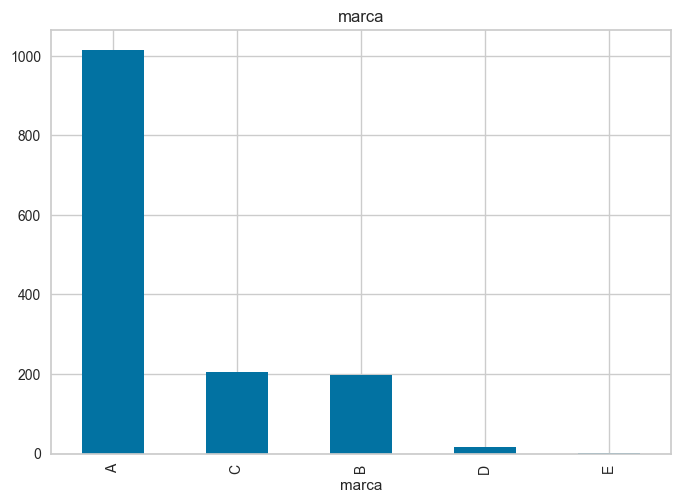

In [13]:
# Observo distintas marcas del producto puiblicado.
plot_hist(data,'marca', is_variable_str=True)

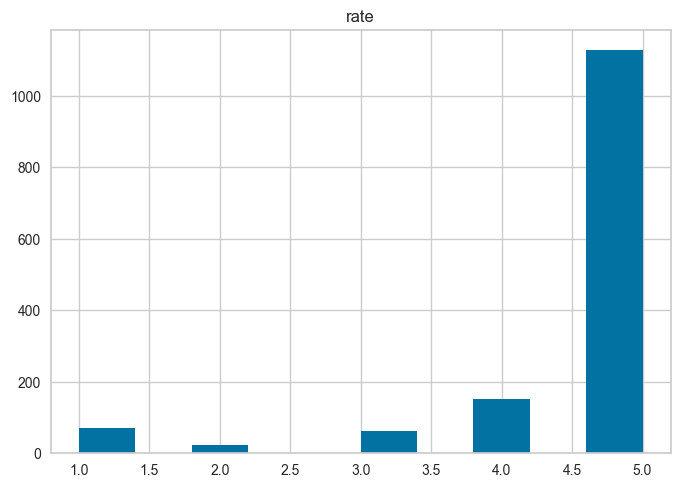

In [14]:
plot_hist(data,'rate', is_variable_str=False)

La mayoria de los productos tienen reviews positivas.

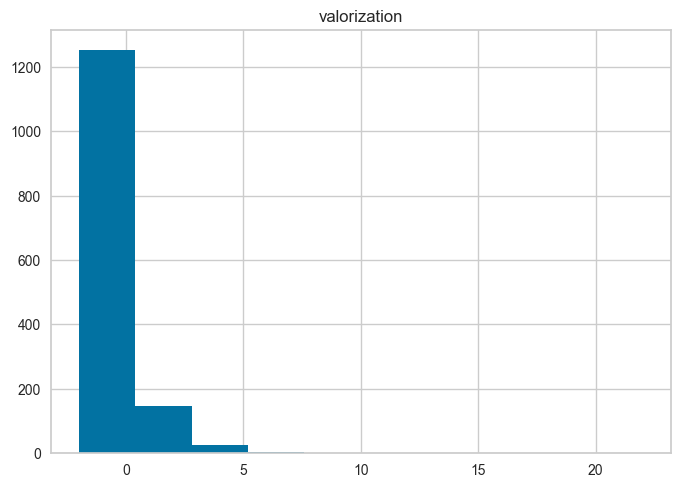

In [15]:
# Vamos a observar la distribucion de la valorizacion.
plot_hist(data,'valorization', is_variable_str=False)

<Axes: xlabel='rate', ylabel='mean_valorization'>

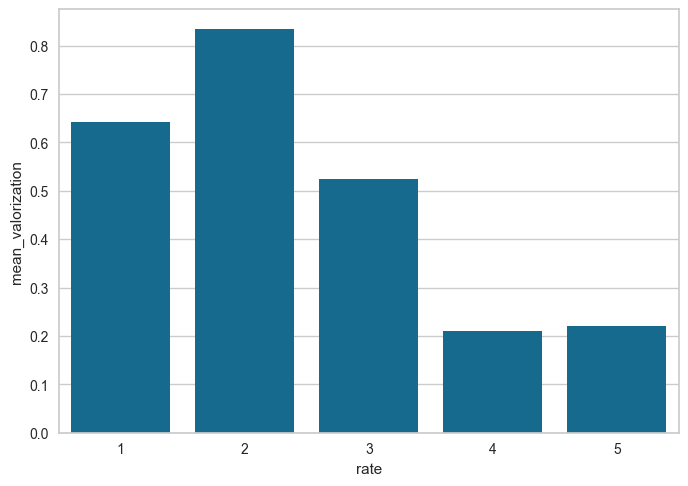

In [16]:
# Vamos a ver la valorizacion promedio por rate.
df_plot = data.groupby('rate')['valorization'].mean().reset_index(name='mean_valorization')
sns.barplot(x='rate', y='mean_valorization', data=df_plot)

La valorizacion pareciera tener valores negativos, y ademas la mayoria de las valorizaciones son nulas.

Habria que evaluar en mas detalle esta variable para ver si influye significativamente.

A primera vista, la utilidad de esta variable podria ser validar, o no, un comentario en X publicacion.

- Idea 1: Incluir la variable 'valorization' como variable mas en el modelo, esto nos ayudaria a reforzar un comentario o no (si tuviera valorizacion negativa).

- Idea 2: Esta variable tambien podria servir para la creacion del target, por ejemplo, un rate de 4 con valoraciones negativas podria ser categorizado como un comentario neutro.

Nota: Como la mayoria de las valoraciones son nulas, creo que es mejor dejarla como feature auxiliar, no como base del target.


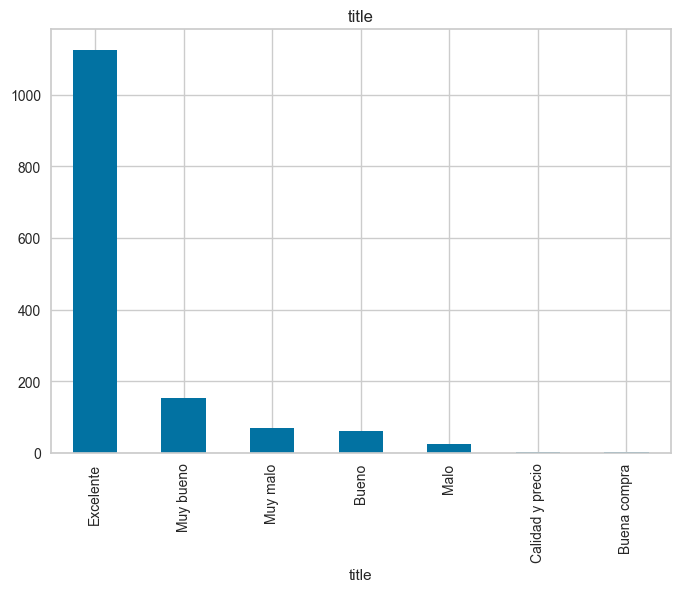

In [17]:
# Vamos a observar la distribucion del titulo.
plot_hist(data,'title', is_variable_str=True)

In [18]:
# Voy a observar si el titulo se condice con el rate.
# Asi tambien de esa manera podre estudiar como se comporta el rate en funcion del titulo, para comenzar a crear el target.
data.groupby(['rate'])['title'].unique()

rate
1                                     [Muy malo]
2                                         [Malo]
3                                        [Bueno]
4                                    [Muy bueno]
5    [Excelente, Calidad y precio, Buena compra]
Name: title, dtype: object

Observando esto vemos que el rate y el titulo estan altamente correlacionados, esto con podria utilizarse para la creacion del target.

---

## Validacion de variables.

Aqui realizaremos algunas validaciones para corroborar que lo que se dice en el enunciado efectivamente se esta cumpliendo.

Y para analizar la relacion entre variables.

In [19]:
# Veo si una marca se corresponde a cada publicacion.
data.groupby(['id_publicacion'])['marca'].nunique().value_counts()

marca
1    353
Name: count, dtype: int64

Aqui estamos validando que a cada publicacion se corresponda un UNICO producto.

In [20]:
# Observo si una publicacion pertenece a una sola categoria.
data.groupby(['id_publicacion'])['id_categoria'].nunique().value_counts()

id_categoria
1    353
Name: count, dtype: int64

Una publicacion pertenece a una unica categoria.

In [21]:
# Una publicacion pertenece a un catalogo.
data.groupby(['id_publicacion'])['id_catalogo'].nunique().value_counts()

id_catalogo
1    353
Name: count, dtype: int64

Una publicacion pertenece a una unico catalogo.

---

## Analisis Exploratorio

### Rate promedio por marca

<Axes: xlabel='marca', ylabel='rate'>

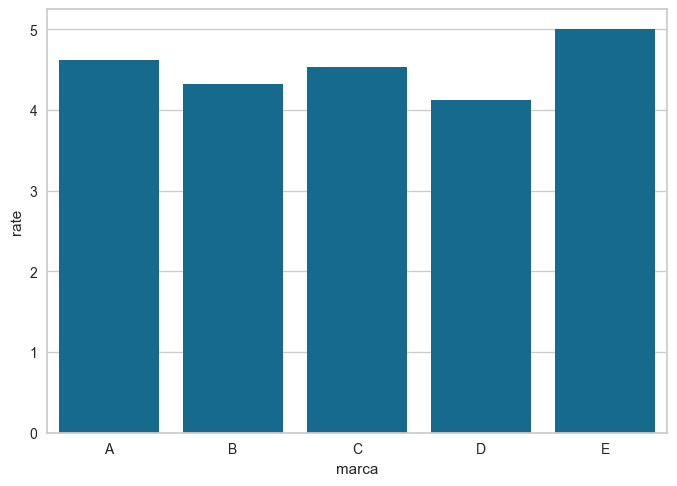

In [22]:
df_plot = data[['marca', 'rate']].groupby('marca').mean().reset_index()
sns.barplot(x='marca', y='rate', data=df_plot)

- La marca 'E' tiene el mayor promedio.
- El promedio de rates entre las distintas marcas es bastante similar.

### Cantidad de comentarios por marca.

<Axes: xlabel='marca', ylabel='count'>

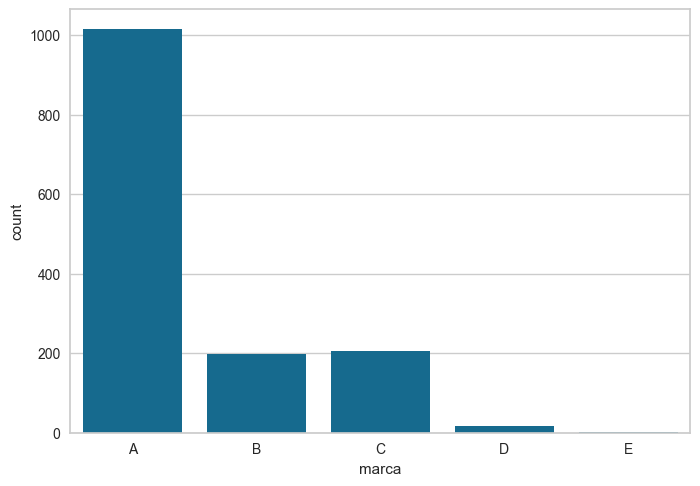

In [23]:
df_plot = data[['marca', 'id_comentario']].groupby('marca').size().reset_index(name='count')
sns.barplot(x='marca', y='count', data=df_plot)

- La marca con mayor cantidad de comentarios es la marca A.
- La marca E es la de menor cantidad de comentarios y solo tiene un unico comentario.

### Publicaciones por marca

<Axes: xlabel='marca', ylabel='count'>

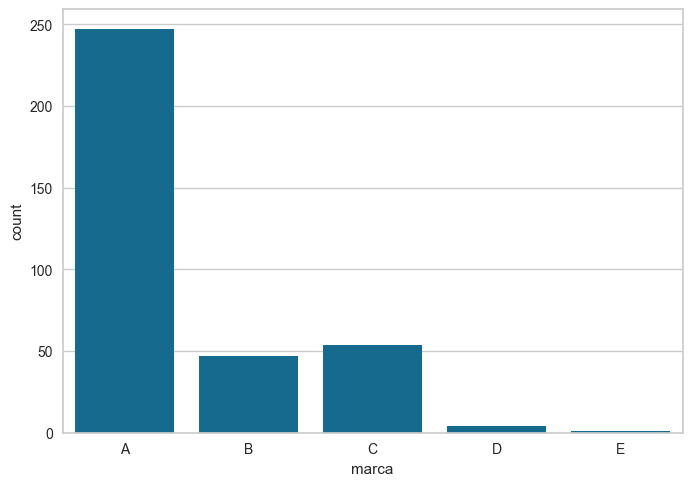

In [24]:
df_plot = data[['marca', 'id_publicacion']].groupby('marca')['id_publicacion'].nunique().reset_index(name='count')
sns.barplot(x='marca', y='count', data=df_plot)

- La marca 'A' es la que mayor cantidad de publicaciones tiene.
- La marca 'E' es la que menor cantidad de publicaciones tiene, una unica, esa unica publicacion se corresponde con el unico comentario en esa marca.

### Cantidad de Catalogos por Marca

<Axes: xlabel='marca', ylabel='count'>

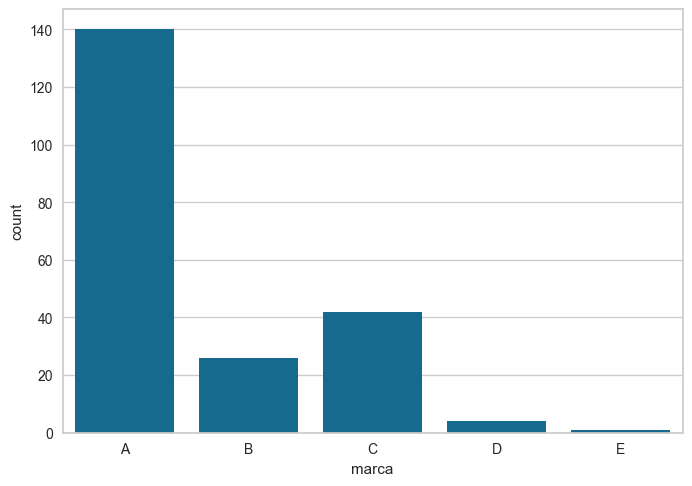

In [25]:
df_plot = data[['marca','id_catalogo']].groupby('marca')['id_catalogo'].nunique().reset_index(name='count')
sns.barplot(x='marca', y='count', data=df_plot)

- La marca 'A' aparece en la mayoria de los catalogos.

### Categorias por Marca

<Axes: xlabel='marca', ylabel='count'>

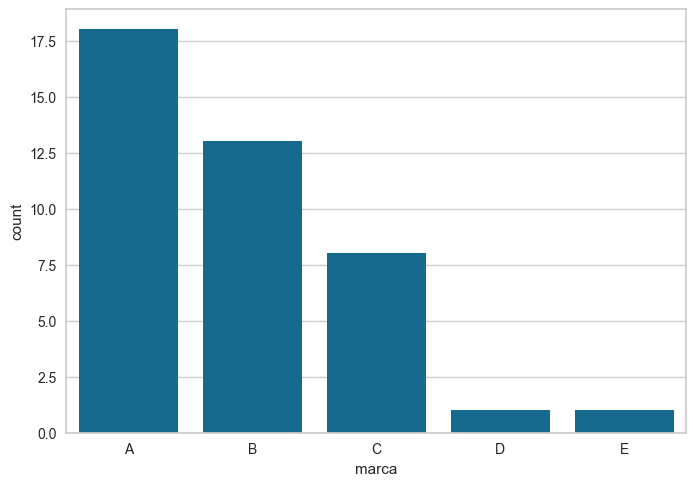

In [26]:
df_plot = data[['marca','id_categoria']].groupby('marca')['id_categoria'].nunique().reset_index(name='count')
sns.barplot(x='marca', y='count', data=df_plot)

- Aqui se observa que la Marca 'B' Aparece en mayor cantidad de categorias que la marca 'C', pero aunque aparezca en mayor cantidad de categorias, puede pasar que un catalogo tenga varias publicaciones de una misma marca, por esa razon la marca 'C' tiene mayor cantidad de comentarios que la marca 'B'

<Axes: xlabel='id_catalogo', ylabel='count'>

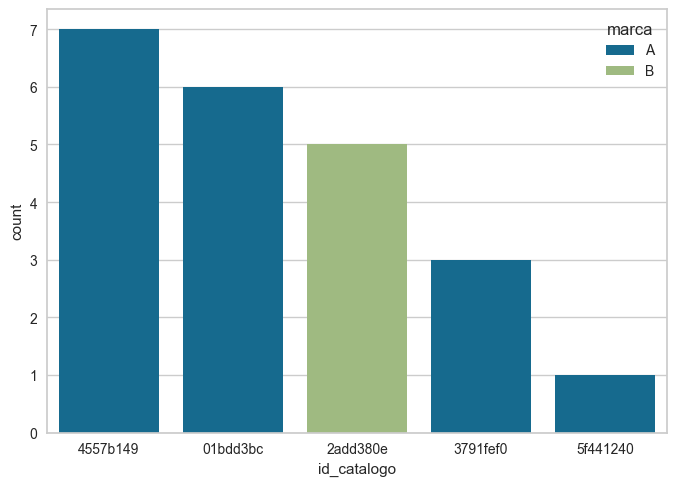

In [27]:
# Puede pasar que un catalogo tenga varias publicaciones de un mismo producto?
df_plot = data[['id_catalogo', 'id_publicacion', 'marca']].drop_duplicates()
df_plot = df_plot.groupby(['id_catalogo', 'marca']).size().reset_index(name='count').sort_values('count', ascending=False)

# Voy a seleccionar los 5 catalogos con mayor cantidad de publicaciones.
id_max_publicaciones = data.groupby(['id_catalogo'])['id_publicacion'].count().sort_values(ascending=False).index
id_max_publicaciones = id_max_publicaciones[0:5].tolist()

df_plot = df_plot[df_plot['id_catalogo'].isin(id_max_publicaciones)]
sns.barplot(x='id_catalogo', y='count', data=df_plot, hue='marca')

En esta muestra podemos observar que un catalogo puede tener varias publicaciones de un mismo producto.

Obs. Generales:
- El promedio de rates entre marcas no varia entrew las diferentes marcas, por lo tanto no parece ser una variable importante para le modelo.

- Puede observarse una distribucion similar en todas las variables (lo que tiene sentido, debido a la correlacion entre la marca y las variables categoria -> catalogo -> publicacion) en donde la mayor cantidad de registros pertenecen a la Marca 'A', y la menor cantidad de registros pertenece a la Marca 'E'.

---

# Labeling

En esta seccion crearemos el target o label para clasificar un comentario como 
- Positivo -> 2
- Neutro -> 1
- Negativo -> 0

In [28]:
def get_labels (rate):
    if rate <= 2:
        return 0
    elif rate == 3:
        return 1
    elif rate >= 4:
        return 2
    else:
        return np.nan

In [29]:
data['rate'].value_counts()

rate
5    1128
4     152
1      70
3      61
2      24
Name: count, dtype: int64

In [30]:
mod_df = data.copy()
mod_df['target'] = mod_df['rate'].apply(get_labels)
mod_df['target'].value_counts()

target
2    1280
0      94
1      61
Name: count, dtype: int64

Como era esperado se tiene un gran desbalance entre la clase positiva y las demas clases.

---

# Preprocesamiento y limpieza de texto

En esta seccion limpiamos y estandarizamos el texto.

Para limpiar el texto procederemos de la siguiente manera:

1. Llevamos toda la cadena de texto a minuscula, para evitar considerar una palabra como token distinta (ej: Producto | producto).

2. Eliminacion de tildes y acentos.

3. Elimnacion de numeros.

4. Eliminacion de signos de puntuacion y caracteres especiales.

5. Eliminacion de espacios multiples.

6. Aplicacion de Lemmatizacion para reducir las palabras a su raiz etimologica. 
    * Lemmatizacion siempre devuelve una version reducida de la palabra, es una palabra de la misma familia (ej: comprando | comprado -> comprar).
    * Se utiliza Lemmatizacion por sobre Stemming ya que, este ultimo, corta los sufijos de las palabras y estas pueden perder significado (ej: compando -> compr).
    * Otra aclaracion, se utilizo el lemmatizador de la libreria spaCY, ya que el lemmatizador de la libreria nltk solo soporta palabras en ingles. Ademas de lo menciondo spaCy es mas confiable ya que soporta texto complejo, reconoce conjucaciones, articulos, adverbios, etc.

    NOTA 26/03 - Se evaluo el modelo al aplicar stemming en vez de lemmtaizacion, el modelo mostro mucha mejor performance al aplicar stemming que al aplicar lemmatizacin.

    <b>Por lo tanto seleccionaremos stemming para reducir las palabras a su raiz etimologica</b>

    Stemming reduce la palabra a su raiz etimologica mediante la sustraccion de sufijos y prefijos de las palabras, la raiz que queda (stem) muchas veces no es una palabra en si.

    Utilizamos el <b>Snowball Stemmer</b> ya que es multi-lingual, y es mucho mas agresivo que otros Stemmers (Porter).

7. Removemos stopwords, se le dice asi a las palabras poco informativas sobre el contenido del texto (preposiciones, pronombres, etc.)

8. <s>Al ir avanzando en el desarrollo de la solucion tambien iremos descubriendo palabras que no aportan nigun tipo de informacion. Por lo tanto, este tipo de palabras propias ("Ventilador", "Producto", "Calor", etc.) las voy a eliminar de mi vocabulario, ya que estoy realizando una clasificacion de sentimientos y quiero resaltar palabras que indiquen positividad o negatividad.</s>

Nota: Este ultimo paso lo aplico ya que puedo darme el lujo de hacerlo, para mejorar la performance del clasificador. Si se tratara de algun LLM no haria este tipo de filtrado ya que los mismos aprenden a partir edl contexto y algunas de las palabras filtradas si podiran aportar informacion util combinadas con otras.

In [31]:
def lemmatization (text, stop_words, context_words, word_to_filter):
    # Como se trata de un DS pequeño, puedo aplicar el modelo preentrenado de spacy large.
    # Estrare sacrificando velocidad por precision.
    nlp = spacy.load('es_core_news_lg')
    
    # Lemmatizacion, esto convierte el ttexto a un objeto Doc que contiene sequencias enriquecidas de Token.
    tokens = nlp(text) 
    
    tokens = [token.lemma_ for token in tokens if (token.lemma_ not in stop_words or token.lemma_ in context_words) and not token.is_punct]
    
    return [token for token in tokens if token not in word_to_filter]

In [32]:
def stemming (text, stop_words, context_words, word_to_filter):
    stemmer = SnowballStemmer(language='spanish')
    
    # Stemming. Transformamos texto a lista ya que el stemmer trabaja sobre string crudos, no sobre
    # linguisticos como lemmatization.
    tokens = text.split() 
    
    tokens = [token for token in tokens if token not in word_to_filter]
    
    return [stemmer.stem(token) for token in tokens if (token not in stop_words or token in context_words)]

In [33]:
# Configuramos las stopwords.
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

# Creamos funcion para limpiar el texto.
def clean_text(text):
    # Transformo texto a minusculas.
    text = str(text).lower()
    
    # Elimino tildes/acentos.
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # Elimino numeros.
    text = re.sub(r'\d+', ' ', text)
    # Elimino signos de puntuacion.
    text = re.sub(r'[^\w\s]', ' ', text)
    # Hay algunos comentarios que tienen la nueva linea como '\n' especificamente
    # reemplazare '\n' -> ' '
    text = re.sub(r'\n', ' ', text)
    # Eliminamos espacios multiples.
    text = re.sub(r'\s+', ' ', text)
    
    # Voy a generar un diccionario que contendra palabras permitidas, para que el texto no pierda contexto,
    # ya que el clasificador puede perder precision con falta de contexto.
    # Las expresiones como "no es bueno", o "no me gusta" pueden perder su sentido si se eliminan las palabras "no" o "me".
    context_words = {'no', 'pero', 'aunque', 'sin', 'ni', 'muy'}
    
    # Voy a eliminar palabras que detecte durante el analisis de datos y no aportan nigun sentido al texto para detectar positividad o negatividad.
    word_to_filter = [
        'ventilador', 'producto', 'habitacion', 'foco', 'lluvia', 'luz', 'iluminar', 'energia',
        'enfriar', 'calentar', 'calor', 'frio', 'corriente', 'aire', 'tornillo', 'instructivo', 'plastico',
        'dia', 'manual', 'velocidad', 'app', 'mes', 'agua', 'x', 'fundir', 'hielo', 'lampara', 'ser',
        'marca', 'dar', 'instalacion', 'potencia', 'programar', 'bateria', 'semana', 'encender', 'humedad', 'iluminacion'
        ]
    
    # Lemmatizamos.
    # tokens = lemmatization(text, stop_words, context_words)
    # Stemmingzamos.
    
    tokens = stemming(text, stop_words, context_words, word_to_filter)
    
    text = ' '.join(tokens)
    
    # Vuelvo a eliminar tildes por si Lemmatizacion introdujo alguna.
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juanb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
def search_char_in_column(df, column, char_to_search):
    # Esta funcion me devolvera un booleano si el caracter se encuentra en la serie.
    # Util para buscar palabras especificas en un texto, lo que hago es escaparle el caracter, esto lo hago
    # ya que si utilizamos un carater de regex, '?' por ejemplo, sera interpretado como un caracter especial.
    column_serie = df[column]
    pattern = re.escape(char_to_search)

    mask =  column_serie.astype(str).str.contains(pattern, regex=True)
    
    return df[mask]

## Drop de comentarios nulos.

Antes de proceder a limpiar el texto dropeare los comentarios que son nulos.

In [35]:
len_prev = len(mod_df)

mod_df.dropna(inplace=True, subset=['content'])
mod_df.reset_index(drop=True, inplace=True)

len_bef = len(mod_df)

print(f'{len_prev - len_bef} registros eliminados')

16 registros eliminados


## Unir title + content.
Algo a tener en cuenta es que unificaremos el campo 'title' con el de 'content', ya que contiene una valorizacion mas especifica del usuario.

In [36]:
mod_df['text_label'] = mod_df['title'] + ' ' + mod_df['content']

mod_df[['title', 'content', 'text_label']].head()

,title,content,text_label
0,Excelente,Lamparas para un bote de 8 centímetros de diám...,Excelente Lamparas para un bote de 8 centímetr...
1,Bueno,"Tengo 10 lámparas de estas, en menos de 2 años...","Bueno Tengo 10 lámparas de estas, en menos de ..."
2,Excelente,Excelente compra muy bonitas.,Excelente Excelente compra muy bonitas.
3,Excelente,Hermosas.,Excelente Hermosas.
4,Excelente,Muy bonita mejor se lo que se ve el la foto.,Excelente Muy bonita mejor se lo que se ve el ...


## Limpieza de texto.

In [37]:
random_index = random.randint(0, len(mod_df))

In [38]:
# Aplicamos la funcion de limpieza de texto y generamos una nueva columna para comparar resultados.
mod_df['text_label_clean'] = mod_df['text_label'].apply(clean_text)

In [39]:
# Comparamos resultados.
for i in range(5):
    random_index = random.randint(0, len(mod_df))
    print(f'Texto original: {mod_df["text_label"][random_index]}')
    print(f'Texto limpio: {mod_df["text_label_clean"][random_index]}')
    print('')

Texto original: Muy bueno Buenas adquisición.
Texto limpio: muy buen buen adquisicion

Texto original: Excelente Muy bueno.
Texto limpio: excelent muy buen

Texto original: Excelente El electricista tardo unos pocos minutos en instalarlas e iluminan muy bien un area que es bastante oscura ya que no ha luces cerca. Espero duren, pero por el momento bastante bien.
Texto limpio: excelent electric tard poc minut instal ilumin muy bien are bastant oscur no luc cerc esper dur per moment bastant bien

Texto original: Bueno Imumina bien, pero no aguanta tanto las descargas habituales.
Texto limpio: buen imumin bien per no aguant descarg habitual

Texto original: Excelente Muy bueno, la luz es agradable, y el precio muy accesible, compré tres espero ver cómo me funcionan.
Texto limpio: excelent muy buen agrad preci muy acces compr tres esper ver funcion



## Exploracion de idioma.

Vamos a estudiar si todos los comentarios estan en español.
Para esto vamos a utilizar la libreria langdetect. Ya que es una libreria de uso simple y rapido

In [40]:
def detect_language (text):
    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'

# Voy a observar si hay comentarios en otro idioma.
mod_df['language'] = mod_df['text_label'].apply(detect_language)
mod_df['language'].value_counts()

language
es    1270
ro     110
pt      23
nl       6
ca       4
so       2
tl       2
en       1
de       1
Name: count, dtype: int64

Luego de revisar los distintos lenguajes detectados, observe que todos son en espanol menos el detectado en ingles.

Por esa Razon lo que haremos es eliminar del vocabulario aquellos comentarios que esten escritos en ingles.

In [41]:
mod_df[mod_df['language'] == 'en']

,id_categoria,id_catalogo,id_publicacion,id_comentario,marca,rate,valorization,title,content,target,text_label,text_label_clean,language
65,89163786,2add380e,f7bace2f,38e74893,B,5,0,Excelente,I think this is an excellent product and i lik...,2,Excelente I think this is an excellent product...,excelent i think this is an excellent product ...,en


In [42]:
# Elimino comentarios en ingles ya que las palabras que lo componen no apareceran en mi vocabulario.
mod_df = mod_df[mod_df['language'] != 'en'].copy().reset_index(drop=True)

## WordCloud.

Usaremos Wordcloud para visualizar de forma exploratoria el contenido de los comentarios, trataremos identificar palabras comunes por clase, ademas que esta tecnica nos permitira validar si la limpieza de texto fue efectiva.

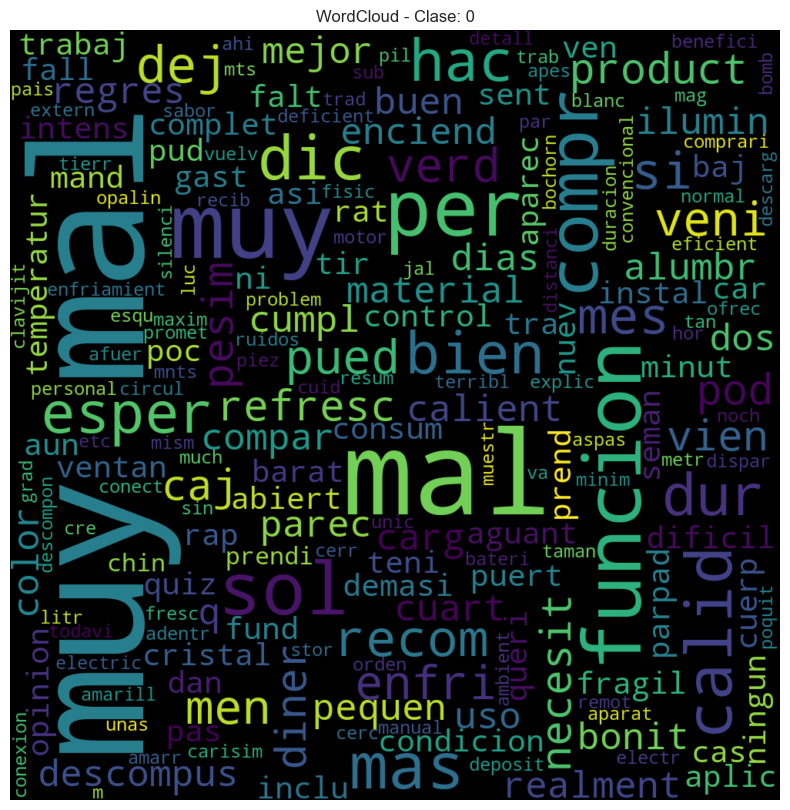

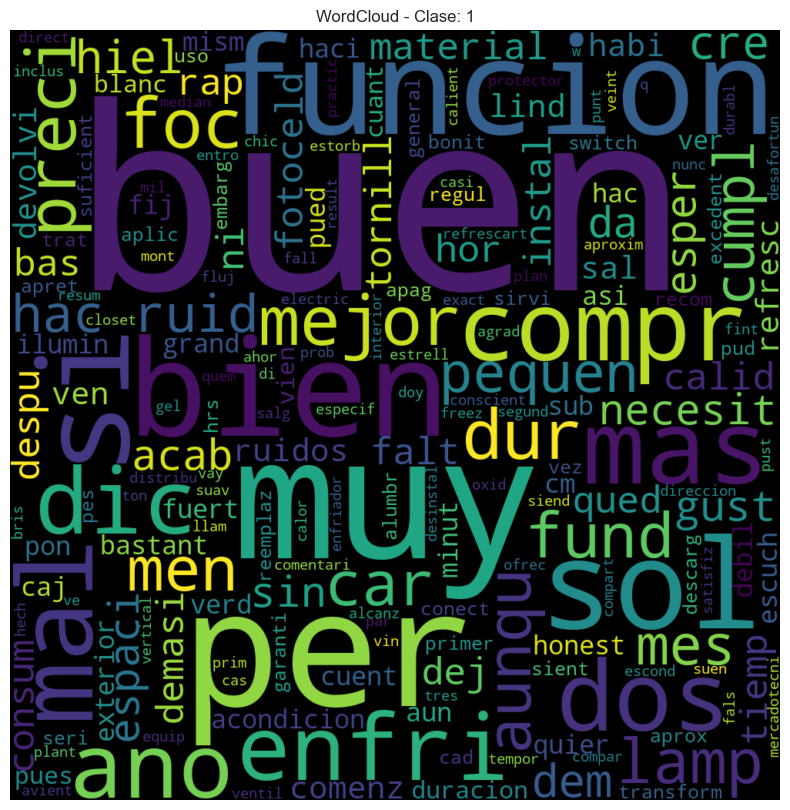

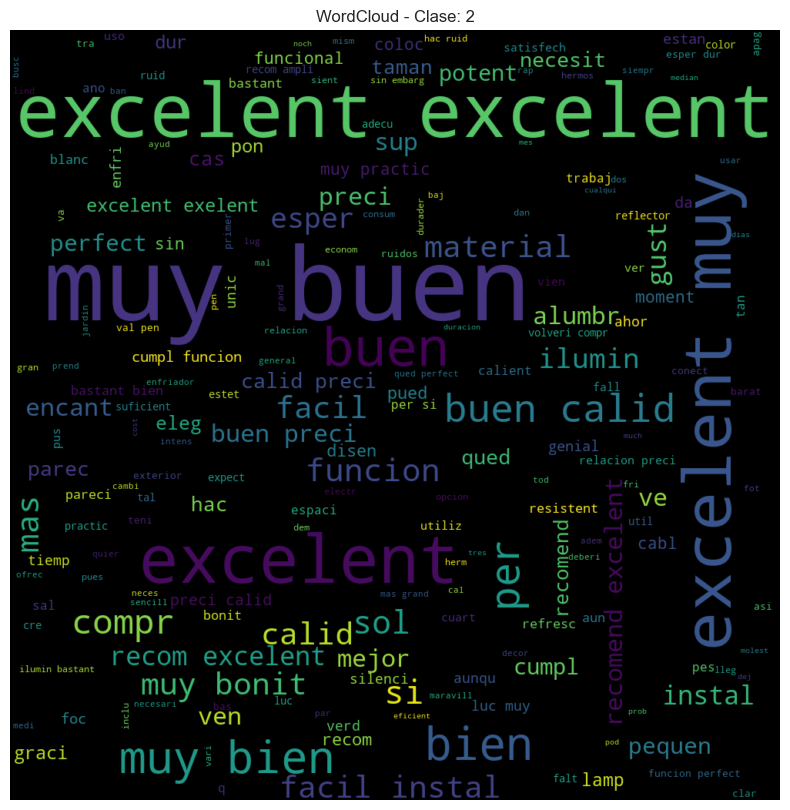

In [43]:
# Vamos a obtener una wordcloud por cada rate que se tenga.
target_list = mod_df['target'].sort_values().unique().tolist()

for target_iter in target_list:
    # Concateno todos los comentarios de un rate en un solo texto.
    text = ' '.join(mod_df[mod_df['target'] == target_iter]['text_label_clean'].str.lower().astype(str))
    
    # Aplico WordCloud al texto generado.
    wordcloud = WordCloud(width = 1000, height = 1000).generate(text)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud - Clase: {target_iter}")
    plt.show()

Al observar el WordCloud generado para cada target pareciera que tiene sentido.

- La clase -1 contiene palabras que idican una review negativa de algun producto ("Malo", "Descomponer", etc.).
- La clase 0 contiene palabras que pueden ser comentarios neutros, que un cliente no esta contento pero tampoco desconforme con el producto ("Bueno", "Pero", etc.).
- La clase 1, contiene palabras relacionadas a una buena review y comentario positivo ("Excelente", "Recomendar", "Genial", etc.)

---

# Preparacion DF Entrenamiento.

Ahora procederemos con el Encoding de los comentarios limpios, contaremos el numero de veces que aparece cada palabra en un comentario y le asignaremos asi un peso correspondiente a dicha palabra en una matriz.

Generaremos 3 diferentes DataSets para entrenar nuestro modelo de clasificacion, cada uno se generara teniendo en cuenta una tecnica distinta: 

1. CountVectorizer -> Representaremos a los comentarios como un conteo de ocurrencias de cada palabra. 
    - La problematica de este enfoque es que simplemente estamos indicando cuantas veces aparece una palabra y no estaremos resaltando la imporancia de la palabra, por ejemplo, hay palabras que aparecen en muchos comentarios y resultan entonces poco informativas.

2. CountVectorizer + Term Frequency Inverse Document Frequency (TF - IDF) -> Al DF anterior le aplicaremos la transformacion TF-IDF. 
    - Esta transformacion comparara el numero de veces que una palabra aparece en un comentario contra el numero de comentarios en la que la palabra aparece. 
    - Este enfoque le da menos importancia a las palabras que aparecen en muchos documentos y resalta palabras mas representativas de cada comentario.

3. TF - IDF y Singular Value Decomposition -> Al DF TF - IDF se le aplicara una reduccion de la dimensionalidad utilizando SVD.
    - SDV consiste en encontrar combinaciones de palabras que resulten informativas y quedarse con las "mejores". Es una transformacion algebraica similar a PCA (Principal Component Analysis) de manera de que podamos describir el DF con un numero de combinaciones menor al numero de terminos que habia originalmente. Las dimensiones que se generan son combinaciones lineales de los terminos.
    - Esta reduccion de la dimensionalidad podria mejorar la performance de un clasificador.

## Seleccion de variables.

In [44]:
index_col = ['id_categoria', 'id_catalogo', 'id_comentario']
features_col = ['text_label_clean']
X = mod_df.set_index(index_col)[features_col].rename(columns={'text_label_clean' : 'text'}).copy()
y = mod_df.set_index(index_col)[['target']].copy()

In [45]:
print('Balance de clase target:')
y.value_counts(normalize=True)*100

Balance de clase target:


target
2         89.069111
0          6.629055
1          4.301834
Name: proportion, dtype: float64

## Division de datos - Train y Test.

Antes de aplicar cualquier transformacion dividiremos los datos en train y test, para evitar data leakage.

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rand_state, test_size=0.32, shuffle=True, stratify=y)

In [47]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (964, 1)
X_test shape: (454, 1)
y_train shape: (964, 1)
y_test shape: (454, 1)


In [48]:
# Validaremos que el balance de la clase target siga igual.
y_train.value_counts(normalize=True)*100

target
2         89.107884
0          6.639004
1          4.253112
Name: proportion, dtype: float64

In [49]:
y_test.value_counts(normalize=True)*100

target
2         88.986784
0          6.607930
1          4.405286
Name: proportion, dtype: float64

## Encoding de texto

Representaremos el texto que compone cada comentario en funcion de las palabras que lo componen. Para esto utilizaremos el texto limpio y lo representaremos como un vector en el espacio de palabras que conforman el vocuabulario.

### CountVecorizer

Al aplicar CountVectorizer vamos a generar un n-grama pequeno para evitar esparcimiento de texto. No seleccionaremos un n-grama de gran dimension (1,3) por ejemplo ya que el vocabulario crece exponencialmente, lo que se necesita mas datos para cubrir bien las combinaciones, si el data-set es chico (como este caso), podriamos generar un sobreajuste.

Al usar n-gramas no tan grandes vamos a estar capturando contexto semantico.

In [50]:
def vectorize_df (X_train, X_test, text_column, ngram=(1,2), max_features=None):
    vectorizer = CountVectorizer(ngram_range=ngram, max_features=max_features)
    
    # Aplico CountVectorizer a los datos de entrenamiento y testeo.
    X_train_count = vectorizer.fit_transform(X_train[text_column]).toarray()
    X_test_count = vectorizer.transform(X_test[text_column]).toarray()
    
    # Genero los DFs de entrenamiento y testeo.
    X_train_count = pd.DataFrame(data=X_train_count, columns=vectorizer.get_feature_names_out(), index=X_train.index)
    X_test_count = pd.DataFrame(data=X_test_count, columns=vectorizer.get_feature_names_out(), index=X_test.index)
    
    return X_train_count, X_test_count, vectorizer

In [51]:
X_train_count, X_test_count, vectorizer_instance = vectorize_df(X_train, X_test, 'text')

print(f'X_train_count shape: {X_train_count.shape}')
print(f'X_test_count shape: {X_test_count.shape}')

X_train_count shape: (964, 4817)
X_test_count shape: (454, 4817)


#### Verificacion de ocurrencias nulas.

Antes de continuar observare si hay columnas cuya suma sea 1 (Se usan en un unico texto).

Si llegara a haber las eliminare. Ya que estas palabras son poco ocurrentes y podrian aparecer en un unico comentario, entonces solo agregan ruido al DF.

In [52]:
unused_words = X_train_count.columns[X_train_count.sum(axis=0) == 1].to_list()

X_train_count.drop(columns=unused_words, inplace=True)
X_test_count.drop(columns=unused_words, inplace=True)

print(f'Cantidad de palabras sin ocurrencias en el set de entrenamiento: {len(unused_words)}')
print(unused_words)

Cantidad de palabras sin ocurrencias en el set de entrenamiento: 3796
['abaj', 'abaj no', 'abast', 'abiert esper', 'abrazader instal', 'abrazader no', 'abrir mas', 'abrir perfor', 'ac', 'ac funcional', 'acab habit', 'acab per', 'acab sol', 'acab veint', 'acamp', 'acamp cas', 'acces compr', 'acept combin', 'acept excelent', 'acer', 'acer deberi', 'aclar', 'aclar pens', 'acogedor', 'acogedor luc', 'acomod qued', 'acomod sugier', 'acondicion hac', 'acondicion no', 'acondicion sin', 'acondicion sol', 'acord preci', 'acril', 'acril bien', 'activ', 'activ correct', 'actualiz', 'actualiz regres', 'acuerd natural', 'acuerd pag', 'acuerd preci', 'ad', 'ad cuad', 'adapt funcion', 'adapt huec', 'adecu consegui', 'adecu entrad', 'adecu estil', 'adecu ilumin', 'adecu preci', 'adecu relacion', 'adecu ventan', 'adem color', 'adem dan', 'adem material', 'adem muy', 'adentr afuer', 'adentr marc', 'ador', 'adorn jardin', 'adorn muy', 'adquiri ban', 'adquiri posterior', 'adquisicion facil', 'afect funcio

#### WordCloud + CountVectorizer

Observaremos ahora una vez aplicado CountVectorizer, la WordCloud que se generara, esto lo haremos para validar nuevamente que las palabras mas frecuentes detectadas tengan relacion con el target.

Para ver que terminos son dominantes numericamente.

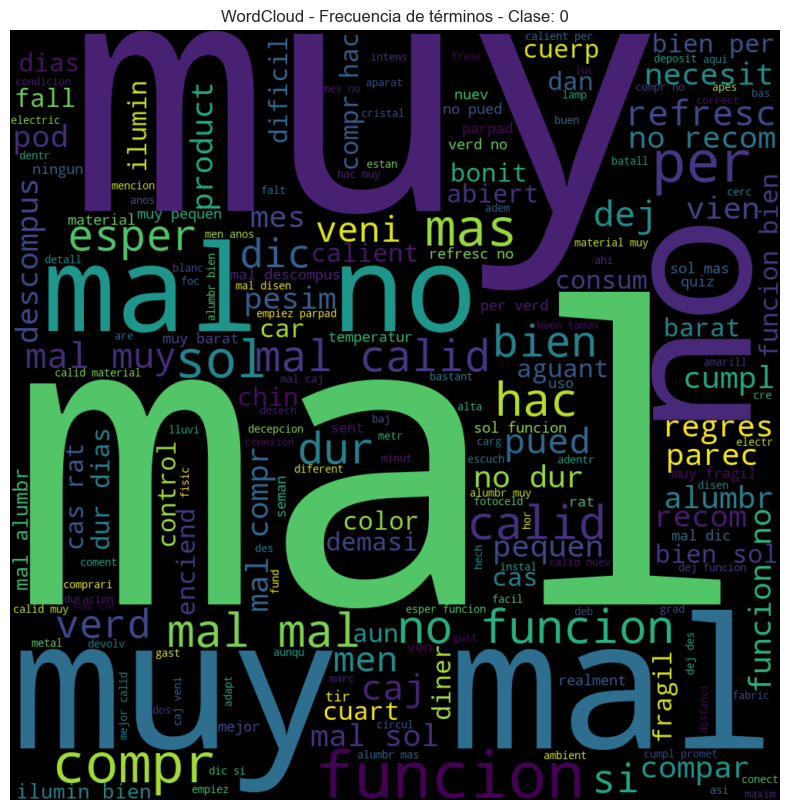

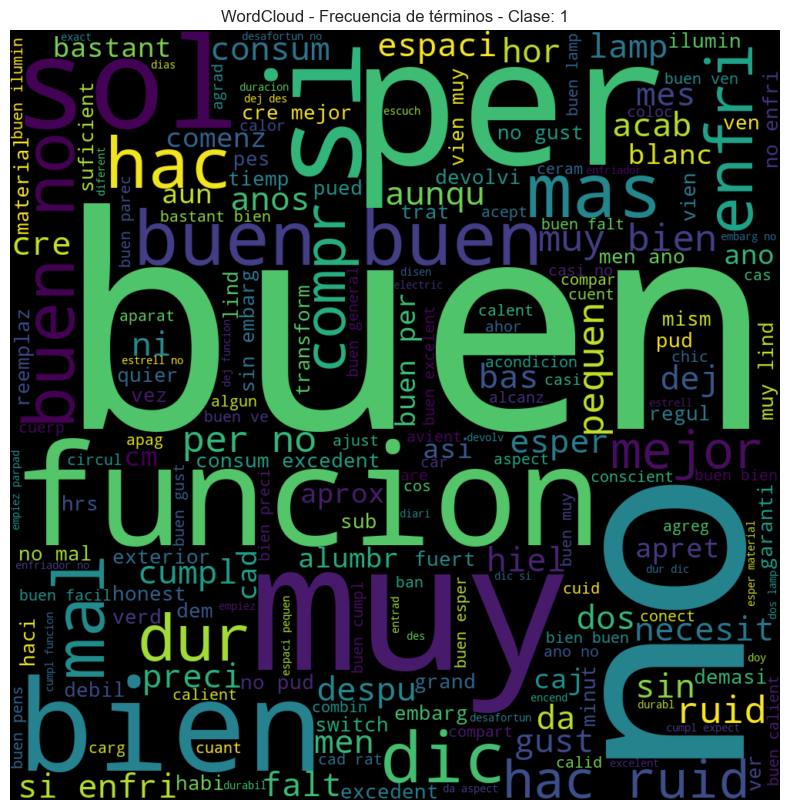

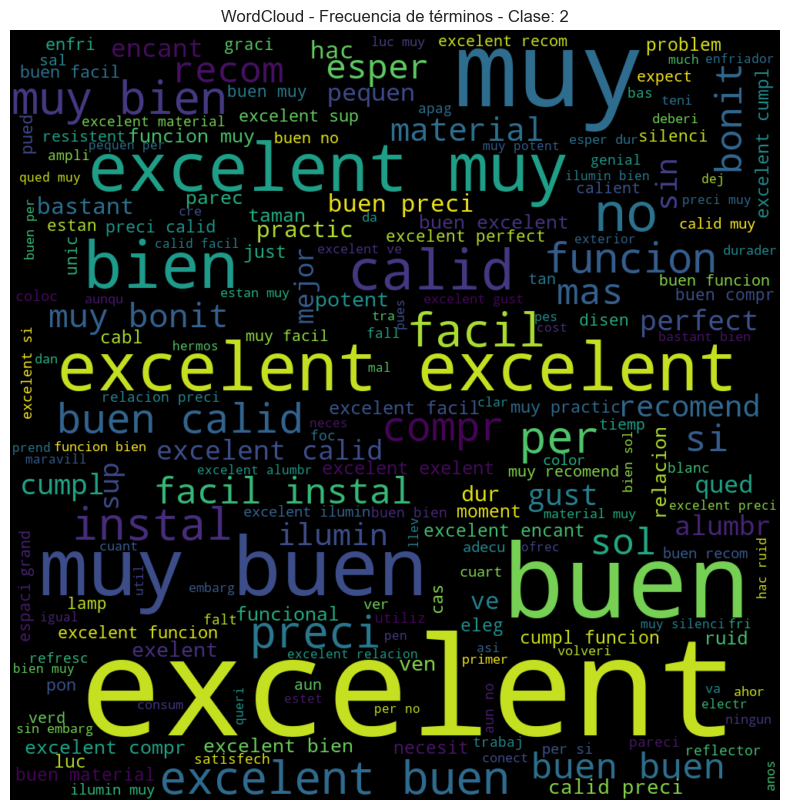

In [53]:
df_plot = X_train_count.copy()
df_plot['target'] = y_train 

for target_iter in target_list:
    df_iter = df_plot[df_plot['target'] == target_iter].copy()
    word_freq = df_iter.drop(columns='target').sum(axis=0).to_dict()
    
    wordcloud = WordCloud(width=1000, height=1000).generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud - Frecuencia de términos - Clase: {target_iter}")
    plt.show()

### TD-IDF.

Aqui voy a usar los n-gramas obtenidos en CountVectorizer.

In [54]:
def get_tf_idf (X_train_vectorized, X_test_vectorized):
    tfidf_transformer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=True)
    
    # Aplico transformacion TF-IDF a los datos de entrenamiento y testeo.
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_vectorized).toarray()
    X_test_tfidf = tfidf_transformer.transform(X_test_vectorized).toarray()
    # Genero DFs de entrenamiento y testeo.
    X_train_tfidf = pd.DataFrame(data=X_train_tfidf, columns=tfidf_transformer.get_feature_names_out(), index=X_train.index)
    X_test_tfidf = pd.DataFrame(data=X_test_tfidf, columns=tfidf_transformer.get_feature_names_out(), index=X_test.index)

    return X_train_tfidf, X_test_tfidf, tfidf_transformer

In [55]:
# Al DF anterior le genero la frequencia de aparicion TF-IDF.
X_train_tfidf, X_test_tfidf, _ = get_tf_idf(X_train_count, X_test_count)

print(f'X_train_tfidf shape: {X_train_tfidf.shape}')
print(f'X_test_tfidf shape: {X_test_tfidf.shape}')

X_train_tfidf shape: (964, 1021)
X_test_tfidf shape: (454, 1021)


### SVD

SVD como bien dijimos reduce la dimensionalidad, sirve cuando tenemos muchas features.
SVD puede suavizar el ruido y captar relaciones latentes en terminos.

Entonces, al usar SVD, voy a ampliar el n_grama creado, llevando el limite superior de 2 palabras a 3, si fuera necesario

In [60]:
def get_svd (X_train, X_test, text_column='text', ngram=(1,2), max_features=None, n_components = None):
    # Primero aplico CountVectorize utilizando el n-grama ingresado por parametro, ademas de la cantidad maxima de features a obtener.
    X_train_svd, X_test_svd, _ = vectorize_df(X_train, X_test, text_column, ngram=ngram, max_features=max_features)
    
    # Remuevo palabras con poca frequencya
    unused_words = X_train_svd.columns[X_train_svd.sum(axis=0) == 1].to_list()
    X_train_svd.drop(columns=unused_words, inplace=True)
    X_test_svd.drop(columns=unused_words, inplace=True)

    # Obtengo matriz TF-IDF.
    X_train_svd, X_test_svd, _ = get_tf_idf(X_train_svd, X_test_svd)
    
    if n_components:
        svd = TruncatedSVD(n_components=n_components, random_state=rand_state)
    else:
        # Para generar las variables voy a utiliar el 70% de las columnas
        svd = TruncatedSVD(n_components=int(X_train_svd.shape[1] * .70), random_state=rand_state)
    
    # Aplico SVD a los datos de entrenamiento y testeo.
    X_train_svd = svd.fit_transform(X_train_svd)
    X_test_svd = svd.transform(X_test_svd)
    # Genero DFs de entrenamiento y testeo.
    X_train_svd = pd.DataFrame(data=X_train_svd, index=X_train.index, columns=[f'sdv_{i}' for i in range (X_train_svd.shape[1])])
    X_test_svd = pd.DataFrame(data=X_test_svd, index=X_test.index, columns=[f'sdv_{i}' for i in range (X_test_svd.shape[1])])

    return X_train_svd, X_test_svd, svd

In [61]:
X_train_svd, X_test_svd, svd = get_svd(
    X_train, 
    X_test, 
    text_column='text', 
    ngram=(1,3), 
    max_features=None,
    n_components=None
)

print(f'X_train_count shape: {X_train_svd.shape}')
print(f'X_test_count shape: {X_test_svd.shape}')

X_train_count shape: (964, 878)
X_test_count shape: (454, 878)


#### Visualizacion de varianza capturada por cada componente creada.

Aqui observaremos cuanta varianza capta cada componente creada, el objetivo de estudiar esto es de que si fuera necesario podriamos reducir el numero de features a considerar y seleccionar aquellas que contengan la mayor varianza explicada acumulada.

Puede pasar que se generen mas componentes de las necesarias, de esa manera por ahi a los 200 componentes ya capturamos el 100% de la varianza, pero si seleccionamos una cantidad mayor de componentes a selecciona, nos estariamos quedando practicamente con ruido.

Por esa razon reduciremos la cantidad de componentes generados hasta considerar aquellos que capturen el 100% de varianza.

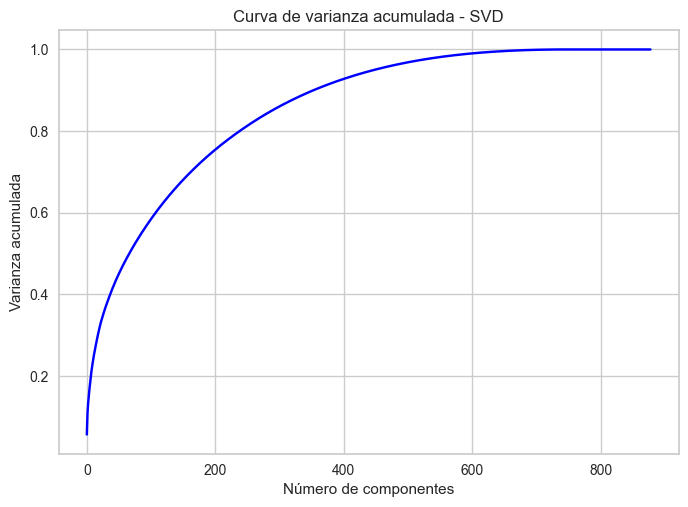

In [62]:
# Varianza acumulada.
plt.plot(np.cumsum(svd.explained_variance_ratio_), label='Varianza acumulada', color='blue')


plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.title('Curva de varianza acumulada - SVD')
plt.grid(True)
plt.show()

Vemos que el 80% de varianza explicada es capturada en los 200 y monedas componentes. 

Y el 100% de la varianza es explicada a los 600 y monedas componente, lo que nos reduce las variables a analizar.

Ahora vamos a reducir la cantidad de componentes, para quedarnos con aquellos que expliquen el 100% de la varianza

In [63]:
# Seleccionamos la cantidad de componentes a utilizar.
varianza_capturada_por_componente = np.cumsum(svd.explained_variance_ratio_)
svd_tresh = 0.95
componentes_significativos = varianza_capturada_por_componente[varianza_capturada_por_componente <= svd_tresh]

X_train_svd = X_train_svd.iloc[:,:len(componentes_significativos)].copy()
X_test_svd = X_test_svd.iloc[:,:len(componentes_significativos)].copy()

print(f'Cantidad de componentes seleccionados = {X_train_svd.shape[1]}')

Cantidad de componentes seleccionados = 448


---

# Entrenamiento y validacion de modelo baseline.

Para encontrar nuestro modelo baseline utilizare la libreria <a href='https://pycaret.gitbook.io/docs/get-started/quickstart'>PYCARET</a>, "una libreria que simplifica y automatiza los flujos de trabajo en Machine Learning".

PyCaret abstrae todo el proceso de entrenamiento de modelos clasicos: preprocesamiento, comparacion entre algoritmos, validacion cruzada, metricas, ajuste de hiperparametros, y generacion de reportes en pocas lineas de codigo, lo que nos permite:
- Probar multiples modelos de clasificacion automaticamente
- Comparar su rendimiento con metricas clave (Accuracy, F1, Recall, etc.)
- Obtener un baseline fuerte como punto de partida
- Seleccionar el mejor modelo para luego optimizarlo manualmente si lo deseamos


El uso de PyCaret nos permite acelerar la etapa de comparación de modelos, centrándonos en el análisis de resultados.  

Obs.: Utilizo PyCaret para poder probar multiples modelos utilizando el menor codigo posible, no utilizo esta libreria para realizar ningun tipo de procesamiento. 

Para la validacion se computaran metricas de evaluacion para los datos de entrenamiento y testo, para tener una idea de como esta ajustando el modelo, si overfittea o underfittea.

Plantearemos una funcion que calculara todas las metricas (Accuracy, Recall, Precision, F1-Score) tanto para train como para test. Asi validaremos el ajuste de los datos.

Si hay una diferencia significativa entre los datos de train y de test significa que el modelo podria haber overfitteado o underfitteado.

In [64]:
models_to_test = ['lr', 'rf', 'svm', 'gbc', 'dt', 'lightgbm']

In [65]:
def train_evaluate_clsf_models (X_train, y_train, X_test, y_test, experiment_name, models_to_compare=None):
    df_train = X_train.merge(y_train, left_index=True, right_index=True)
    df_test = X_test.merge(y_test, left_index=True, right_index=True)
    funct_clsf = setup(
        experiment_name=experiment_name,
        data= df_train,
        target=y_train.columns[0],
        test_data=df_test,
        fold=10,                           # PyCaret por defecto utiliza cross-valdiation.
        fold_strategy='stratifiedkfold',
        session_id=rand_state,
        preprocess=True,                   # Haremos un preprocesamiento para mejorar la performance de los modelos.
        remove_multicollinearity=False,
        remove_outliers=False,
        fix_imbalance=True,                # Vamos a tratar el alto desbalance de clase.
        fix_imbalance_method=SMOTEENN(     # Utilizaremos SMOTEENN para balancear la clase target.
            random_state=rand_state, 
            sampling_strategy='minority'
            ), 
        normalize=False,
        pca=False,
        feature_selection=False
    )
    
    funct_best_model = compare_models(
        include=models_to_compare, 
        sort='Accuracy',
        round=3, # Redondeo aplicado a valores de metricas, 2 decimales.
        cross_validation=True
    )
    
    return funct_best_model

In [66]:

# La siguiente funcion evaluara el modelo seleccionado ganador segun pycaret.
# Se evaluara el modelo con los sets de entrenamiento y testeo, con el objetivo de detectar overfitting.
def valdiate_model (model_instance, X_train, y_train, X_test, y_test):
    # Realizamos las predicciones.
    # Train
    y_train_pred = model_instance.predict(X_train)
    # Test
    y_test_pred = model_instance.predict(X_test)
    
    print('-'*60)
    print(f'Metricas Train...\n {classification_report(y_train, y_train_pred)}')
    print('-'*60)
    print(f'Metricas Test...\n {classification_report(y_test, y_test_pred)}')
    print('-'*60)
    
    # Matriz train
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)
    
    # Grafico las matrices de confusion una al lado de la otra.
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    
    sns.heatmap(cm_train, annot=True, ax=axs[0], cbar=False, fmt='d', cmap='Blues')
    axs[0].set_title("Matriz de Confusión - Train")
    axs[0].set_xlabel("Predicted")
    axs[0].set_ylabel("Actual")
    
    sns.heatmap(cm_test, annot=True, ax=axs[1], cbar=False, fmt='d', cmap='Blues')
    axs[1].set_title("Matriz de Confusión - Test")
    axs[1].set_xlabel("Predicted")
    axs[1].set_ylabel("Actual")
    
    plt.tight_layout()
    plt.show()

---

## Modelo 1

Este modelo se entrenara utilizando la matriz generada por CountVectorizer.

In [67]:
bst_mdl_count = train_evaluate_clsf_models(
    X_train_count, 
    y_train, 
    X_test_count, 
    y_test, 
    experiment_name='countvectorizer_clsf',
    models_to_compare=models_to_test    
    )

,Description,Value
0,Session id,24
1,Target,target
2,Target type,Multiclass
3,Original data shape,"(1418, 1022)"
4,Transformed data shape,"(2191, 1022)"
5,Transformed train set shape,"(1737, 1022)"
6,Transformed test set shape,"(454, 1022)"
7,Numeric features,1021
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.996,0.998,0.996,0.996,0.996,0.979,0.980,0.509
dt,Decision Tree Classifier,0.989,0.982,0.989,0.990,0.989,0.944,0.946,0.128
gbc,Gradient Boosting Classifier,0.985,0.000,0.985,0.989,0.985,0.927,0.928,0.819
lr,Logistic Regression,0.981,0.000,0.981,0.981,0.980,0.901,0.903,0.563
svm,SVM - Linear Kernel,0.975,0.000,0.975,0.978,0.975,0.870,0.874,0.146
rf,Random Forest Classifier,0.970,0.996,0.970,0.970,0.965,0.837,0.843,0.456


------------------------------------------------------------
Metricas Train...
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        64
           1       0.95      1.00      0.98        41
           2       1.00      1.00      1.00       859

    accuracy                           1.00       964
   macro avg       0.98      0.99      0.99       964
weighted avg       1.00      1.00      1.00       964

------------------------------------------------------------
Metricas Test...
               precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       0.95      1.00      0.98        20
           2       1.00      1.00      1.00       404

    accuracy                           1.00       454
   macro avg       0.98      0.98      0.98       454
weighted avg       1.00      1.00      1.00       454

------------------------------------------------------------


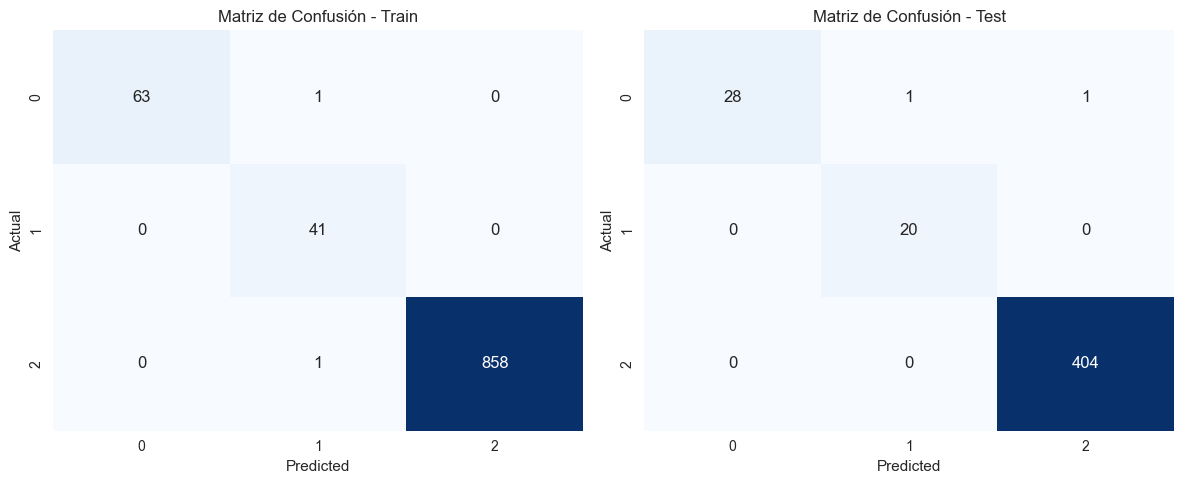

In [68]:
valdiate_model(bst_mdl_count, X_train_count, y_train, X_test_count, y_test)

## Modelo 2

Este modelo se entrenara teniendo en cuenta la matriz generada por CountVectorizer + TD-IDF.

In [69]:
bst_mdl_tfidf = train_evaluate_clsf_models(
    X_train_tfidf, 
    y_train, 
    X_test_tfidf, 
    y_test, 
    experiment_name='tfidf_clsf',
    models_to_compare=models_to_test    
    )

,Description,Value
0,Session id,24
1,Target,target
2,Target type,Multiclass
3,Original data shape,"(1418, 1022)"
4,Transformed data shape,"(1958, 1022)"
5,Transformed train set shape,"(1504, 1022)"
6,Transformed test set shape,"(454, 1022)"
7,Numeric features,1021
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.980,0.955,0.980,0.983,0.980,0.903,0.906,0.116
gbc,Gradient Boosting Classifier,0.966,0.000,0.966,0.971,0.963,0.813,0.825,0.671
lightgbm,Light Gradient Boosting Machine,0.964,0.996,0.964,0.975,0.966,0.828,0.834,0.531
rf,Random Forest Classifier,0.953,0.992,0.953,0.967,0.957,0.780,0.785,0.178
svm,SVM - Linear Kernel,0.934,0.000,0.934,0.960,0.941,0.714,0.725,0.123
lr,Logistic Regression,0.914,0.000,0.914,0.924,0.907,0.499,0.514,0.154


------------------------------------------------------------
Metricas Train...
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        64
           1       0.84      1.00      0.91        41
           2       1.00      0.99      1.00       859

    accuracy                           0.99       964
   macro avg       0.95      0.99      0.96       964
weighted avg       0.99      0.99      0.99       964

------------------------------------------------------------
Metricas Test...
               precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       0.87      1.00      0.93        20
           2       1.00      1.00      1.00       404

    accuracy                           0.99       454
   macro avg       0.96      0.98      0.96       454
weighted avg       0.99      0.99      0.99       454

------------------------------------------------------------


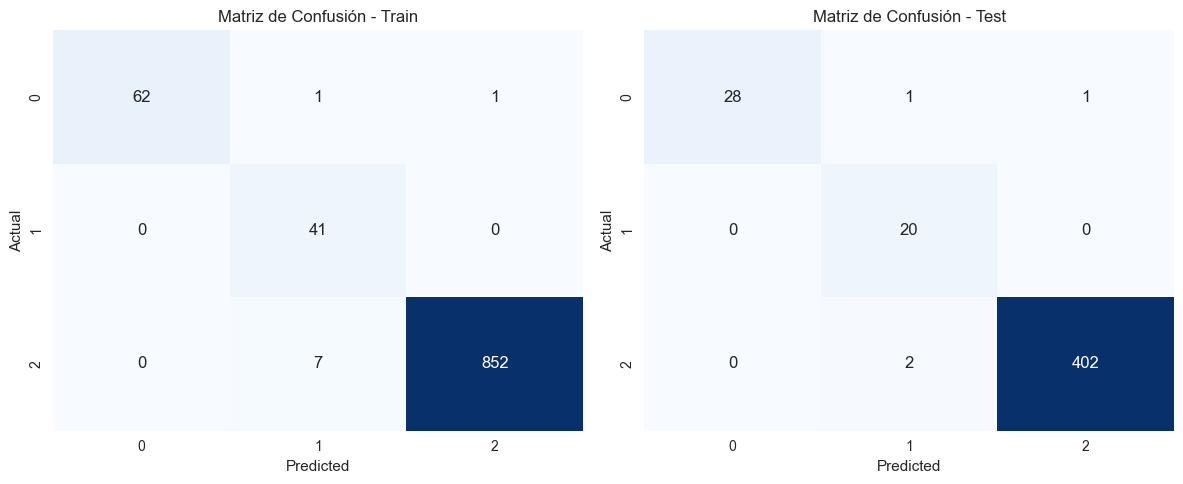

In [70]:
valdiate_model(bst_mdl_tfidf, X_train_tfidf, y_train, X_test_tfidf, y_test)

## Modelo 3

Este modelo se entrenara tienendo en cuanta la matriz generada luego de aplicar CountVectorizer + IF-IDF + SVD.

In [71]:
bst_mdl_svd = train_evaluate_clsf_models(
    X_train_svd, 
    y_train, 
    X_test_svd, 
    y_test, 
    experiment_name='svd_clsf',
    models_to_compare=models_to_test
    )

,Description,Value
0,Session id,24
1,Target,target
2,Target type,Multiclass
3,Original data shape,"(1418, 449)"
4,Transformed data shape,"(1972, 449)"
5,Transformed train set shape,"(1518, 449)"
6,Transformed test set shape,"(454, 449)"
7,Numeric features,448
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.949,0.990,0.949,0.963,0.951,0.755,0.760,1.607
svm,SVM - Linear Kernel,0.944,0.000,0.944,0.945,0.941,0.688,0.697,0.059
rf,Random Forest Classifier,0.929,0.985,0.929,0.928,0.915,0.532,0.571,0.191
gbc,Gradient Boosting Classifier,0.924,0.000,0.924,0.962,0.931,0.662,0.675,5.287
lr,Logistic Regression,0.916,0.000,0.916,0.923,0.907,0.497,0.514,0.062
dt,Decision Tree Classifier,0.909,0.880,0.909,0.951,0.921,0.612,0.627,0.097


------------------------------------------------------------
Metricas Train...
               precision    recall  f1-score   support

           0       1.00      0.66      0.79        64
           1       0.64      1.00      0.78        41
           2       0.99      0.99      0.99       859

    accuracy                           0.96       964
   macro avg       0.88      0.88      0.85       964
weighted avg       0.97      0.96      0.96       964

------------------------------------------------------------
Metricas Test...
               precision    recall  f1-score   support

           0       1.00      0.73      0.85        30
           1       0.75      0.75      0.75        20
           2       0.98      1.00      0.99       404

    accuracy                           0.97       454
   macro avg       0.91      0.83      0.86       454
weighted avg       0.97      0.97      0.97       454

------------------------------------------------------------


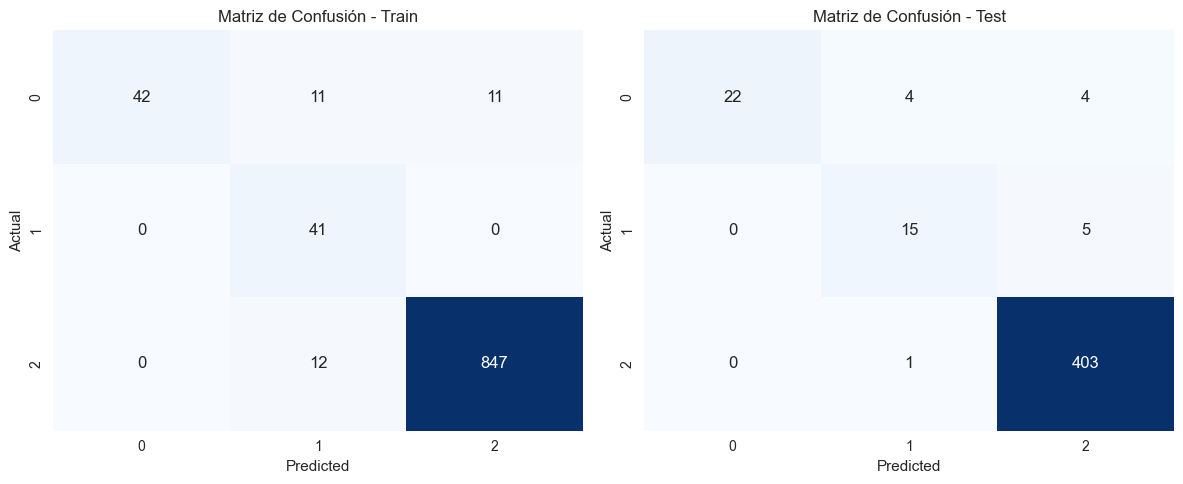

In [72]:
valdiate_model(bst_mdl_svd, X_train_svd, y_train, X_test_svd, y_test)

Luego de mirar al detalle las metricas de entrenamiento y test de cada modelo planteado podemos decir:

- No se observa Overfitting ni Underfitting, si bien hay metricas en train y test que dan 1.0, el gap entre ellas es bajo, por lo tanto no hay graves problemas de overfittero, esto significa que el modelo esta generalizando bien.

- Las metricas son solidas incluso para clases desbalanceadas.

- El Accuracy en todos los modelos da bastante alto, lo que indica que los modelos son bastante precisos con sus predicciones.

_ En cuanto a la clase 0 (Comentarios Negativos), todos los modelos detectan esta clase correctamente, la precision y recall suelen ser altos.

- En cuanto a la clase 1 (Comentario Neutro), el modelo 1 es el que mejor las clasifica ya que es el que menos faltsos positivos y negativos detecta para esa clase. Modelo 2 cae un poco y modelo 3 confunde bastante.

_ Clase 2 (Comentario Positivo), todos los modelos detectan esta clase de manera optima, siendo el modelo 3 el que mas predicciones erroneas realiza.

- Modelo 1 (CountVectorizer):
    * Metricas altas en todas las clases, en train y test.
    * Muy buen balance entre Precision y Recall, por lo que el f1-score da alto.
    * Un buen clasificador, puede verse en las matrices de confusion que hay una presencia minima en falsos positivos y falsos negativos.
    * Este modelo utiliza la tecnica de preprocesamiento mas simple y aun asi logra la mejor performance.

- Modelo 2 (CountVectorizer + IF-IDF):
    * Metricas altas en todas las clases, tanto en train y test.
    * Caida en el valor de la precision en test para la clase 1, esto puede verse en la matriz de confusion, hubo un incremento en falsos positivos para la clase en mencion (cosa que el modelo 1 no hizo).
    * Tiene una performance solida como el modelo anterior pero, no es tan bueno como el modelo anteior.

- Modelo 3 (CountVectorizer + IF-IDF + SVD):
    * El modelo que peor performa de los 3 planteados.
    * Las metricas de evaluacion son mas chicas que los demas modelos.
    * Al observar las matrices de confusion podemos ver que hay mayor presencia de falsos positivos y negativos.
    * El modelo generaliza bien, ya que las diferencias entre los datos de train y test son similares.


Seleccionamos el Modelo 1 CountVectorizer, como modelo ganador.

Debido a que el Modelo 1:
- Fue el modelo que mejor performo, tiene metricas altas y estables tanto en train como test.
- Es el mejor detector de clases, incluso la clase neutra, que suele ser la mas compleja de detectar.
- Las matrices de confusion presentan la menor cantidad de falsos negativos y positivos.
- No hay señales de overfitting (el modelo generaliza de manera correcta, y la diferncia entre score de test y train son pequeñas).
- Mostro una buena performance frente al gran desbalance de clases.
- Un beneficio de este modelo es que cuando se quiera productivizar, la logica de preparacion de datos tendra menos logica y menor complejidad, ya que no se requiere aplicar transformacion TF-IDF ni SVD.

---

# Ajuste de hiper-parametros y validacion modelo ganador.

Ahora voy a proceder a entrenar el modelo ganador nuevamente, para luego realizar una busqueda de hiperparametros y posterior validacion.

## Entrenamiento LightGBM baseline.

In [73]:
# Voy a entrenar nuevamente el modelo ganador, lightgbm, ya que si utilizo el modelo ganador obtenido mediante 
# compare_models() puede ser que otras ejecuciones no termine siendo el ganador, y el modelo instanciado puede ser diferente a lightgbm.
# Mantengo setup.
clf = setup(
        experiment_name='baseline_clsf',
        data= X_train_count.merge(y_train, left_index=True, right_index=True),
        target=y_train.columns[0],
        test_data=X_test_count.merge(y_test, left_index=True, right_index=True),
        fold=10,                           # PyCaret por defecto utiliza cross-valdiation.
        fold_strategy='stratifiedkfold',
        session_id=rand_state,
        preprocess=True,                   # Haremos un preprocesamiento para mejorar la performance de los modelos.
        remove_multicollinearity=False,
        remove_outliers=False,
        fix_imbalance=True,                # Vamos a tratar el alto desbalance de clase.
        fix_imbalance_method=SMOTEENN(     # Utilizaremos SMOTEENN para balancear la clase target.
            random_state=rand_state, 
            sampling_strategy='minority'
            ), 
        normalize=False,
        pca=False,
        feature_selection=False
    )

,Description,Value
0,Session id,24
1,Target,target
2,Target type,Multiclass
3,Original data shape,"(1418, 1022)"
4,Transformed data shape,"(2191, 1022)"
5,Transformed train set shape,"(1737, 1022)"
6,Transformed test set shape,"(454, 1022)"
7,Numeric features,1021
8,Preprocess,True
9,Imputation type,simple


In [74]:
baseline_lgbm = create_model('lightgbm')
print(baseline_lgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9897,0.9940,0.9897,0.9898,0.9890,0.9480,0.9495
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,0.9897,1.0000,0.9897,0.9910,0.9900,0.9521,0.9533
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,0.9896,0.9902,0.9896,0.9917,0.9901,0.9481,0.9495
7,0.9896,1.0000,0.9896,0.9917,0.9897,0.9458,0.9463
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=24, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


## Ajuste de hiper-parametros.

No hay mucho que mejorar, pero, vamos a tratar de mejorar un poco mas.

Para esto usaremos el metodo tune_model() de PyCaret, le pasaremos una lista de posibles parametros para probar grid search CV y veremos si hay alguna combinacion que mejore nuestro modelo baseline.

In [75]:
custom_lgbm_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 5, 7, 10],
    'num_leaves': [5, 10, 20, 31, 50],
    'min_child_samples': [5, 10, 20, 30, 50],
    'boosting_type': ['gbdt'],
    'min_split_gain': [0.05, 0.1, 0.3],
    'min_data_in_leaf': [5, 10, 20],
}

tuned_lgbm = tune_model(
    baseline_lgbm, 
    optimize='f1', 
    fold=5, 
    n_iter=30,
    search_library='scikit-learn',
    search_algorithm='random',
    custom_grid=custom_lgbm_grid
)
print(tuned_lgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9948,0.9943,0.9948,0.9948,0.9947,0.9734,0.9738
1,0.9948,1.0000,0.9948,0.9954,0.9950,0.9746,0.9749
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,0.9896,0.9967,0.9896,0.9917,0.9901,0.9492,0.9498
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
Mean,0.9959,0.9982,0.9959,0.9964,0.9959,0.9795,0.9797
Std,0.0039,0.0023,0.0039,0.0032,0.0037,0.0191,0.0188


Fitting 5 folds for each of 30 candidates, totalling 150 fits
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=5,
               min_child_samples=5, min_child_weight=0.001, min_data_in_leaf=10,
               min_split_gain=0.3, n_estimators=100, n_jobs=-1, num_leaves=20,
               objective=None, random_state=24, reg_alpha=0.0, reg_lambda=0.0,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


## Validacion de resultados.

Generare una funcion para validar los resultados obtenidos, asi comparare este modelo contra el al cual se le ajustaran los hiper-parametros.

Que estaremos observando en este analisis? 

Utilizaremos el modelo para predecir sobre los datos de test, y evaluaremos:

1. Metricas generales:
    
    Utilizando 'clasification_report()' obtendremos las metricas de precision(que tan preciso es el clasificador para predecir instancias positivas), recall(proporcion de positivos correctamente predichos), y f1-score (medida armonica entre recall y precision).
    
    La metrica que se intenta maximizar sera F1-Score, ya que nos interesa un equilibrio entre precision y recall, ya que no podemos aceptar falsos negativos, y debemos estar seguro de los verdaderos positivos.

2. Matriz de confusion:

    Veremos visualmente como fueron las predicciones, que clases estan siendo correctamente clasificadas y cuales estan siendo confundidas.

    Aqui veremos si hay alguna clase que cueste clasificar mas que otra, de la misma manera que hicimos en la seccion anterior al seleccionar un modelo ganador.

3. Curva ROC y AUC:

    Evaluaremos la relacion entre specificity-False Positive Rate (que tan especifico es el clasificador al predecir instancias negativas) y recall-True Positive Rate. Veremos como se comporta el modelo al clasificar en distintos umbrales de probabilidad.

    Lo que se busca es que la curva ROC este lo mas pegada posible al vertice izquierdo superior, esto indica que el modelo tiene un buen nivel de generalizacion.

    Por otra parte, el AUC (Area Under the Curve), resume en una sola metrica la relacion que muestra el grafico ROC, y sus valores se interpretan:
    * AUC = 1 -> Modelo Perfecto.
    * AUC = 0.5 -> Modelo Aleatorio.
    * AUC < 0.5 -> Modelo Malo.

4. Curva Precision-Recall:

    Evaluaremos la relacion entre precision y recall para distintos umbrales de decision, de manera similar que la curva ROC.

    Esta curva es util cuando existe un desbalance de clases, como en nuestro caso. Ya que se enfoca en la relacion entre Falsos Positivos y Verdaderos Positivos.

    Lo ideal es obtener una curva lo mas cercanas posibles al punto (1,1). Esto indica que el modelo tiene una alta precision y un alto recall.

5. Feature Importance y explicabilidad del modelo.

    Trataremos de interpretar como el modelo hace las predicciones mediante el analisis de las variables mas importantes.

    Validaremos con dos enfoques:
    
    * Feature Importance tradicional.
    
        Utiliando el atributo 'feature_importances_' de la instancia del modelo creado, visualizaremos los pesos que le asigno el mismo a cada variable.

        De Esta manera veremos cuales son las variables que mas peso tienen a la hora de realizar las predicciones.
    
    * SHAP.

        SHAP es una libreria que permite darle explicabilidad al modelo, se logra una explicacion mas detallada y precisa de la importancia de las variables.

        Usando SHAP podremos ver y entender como contribuye cada feature en la prediccion de una clase especifica.

        Esto es util para justificar las elecciones del modelo, o identificar variables que tienen mayor impacto en la clasificacion. Ademas podremos detectar si alguna variable introduce sesgos o ruido.

In [76]:
def model_validation(model_instance, X_train, X_test, y_train, y_test):
    # Predicciones.
    y_pred = model_instance.predict(X_test)
    # Probabilidad de las predicciones.
    y_pred_proba = model_instance.predict_proba(X_test)
    # Binarizamos las etiquetas, basicamente:
    # clase 1 -> [1,0,0]
    # clase 2 -> [0,1,0]
    #clase 3 -> [0,0,1]
    clases = model_instance.classes_
    # Transformo a y_test.
    y_test_bin = label_binarize(y_test, classes=clases)
    
    # Metricas generales
    print('-'*50)
    print('Clasification Report...')
    print(classification_report(y_test, y_pred))
    
    # Matriz de confusion.
    print('-'*50)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8.3,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel("Pred")
    plt.ylabel("Real")
    plt.title("Confusion Matrix - Test")
    plt.show()
    
    
    # Curva ROC, como tenemos varias clases para obtener el AUC debemos obtener el promedio de cada clase.
    print('-'*50)

    # AUC macro promedio.
    auc_score = np.round(roc_auc_score(y_test_bin, y_pred_proba, average='macro', multi_class='ovr'),2)
    
    print(f"AUC Promedio = {auc_score}")
    skplt.metrics.plot_roc_curve(y_test, y_pred_proba)
    plt.show()
    
    # Curva Precision-Recall.
    print('-'*50)
    plt.figure(figsize=(8.3,6))
    for i, class_label in enumerate(clases):
        precision, recall, _ = precision_recall_curve(y_test_bin[:,i], y_pred_proba[:,i])
        ap = np.round(average_precision_score(y_test_bin[:,i], y_pred_proba[:,i]),2)
        plt.plot(recall,precision,label=f'Clase {class_label} - Precision Score Promedio = {ap}')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve por Clase")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Feature Importance.
    print('-'*50)
    # Creo un DF con las variables y sus importancias.
    feature_importance = pd.DataFrame({
        'feature' : X_train.columns,
        'importance' : model_instance.feature_importances_
    })
    
    # Ordeno para quedarme con las n primeras.
    n = 20
    feature_importance = feature_importance.sort_values(by='importance', ascending=False).head(n)

    plt.figure(figsize=(8.3,6))
    plt.barh(feature_importance['feature'][::-1], feature_importance['importance'][::-1])
    plt.title(f"Top {n} palabras más importantes")
    plt.xlabel("Importancia")
    plt.tight_layout()
    plt.show()
    
    # Shap
    print('-'*50)
    plt.figure(figsize=(8.3,6))    
    explainer = shap.Explainer(model_instance,X_test)
    shape_values = explainer(X_test)
    
    for i, class_label in enumerate(clases):
        print(f'SHAP - Feature Importance - Clase: {class_label}')
        shap.plots.bar(shape_values[:,:,i], max_display=n-7)
    print('-'*50)

### Validacion Modelo Baseline.

--------------------------------------------------
Clasification Report...
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       0.95      1.00      0.98        20
           2       1.00      1.00      1.00       404

    accuracy                           1.00       454
   macro avg       0.98      0.98      0.98       454
weighted avg       1.00      1.00      1.00       454

--------------------------------------------------


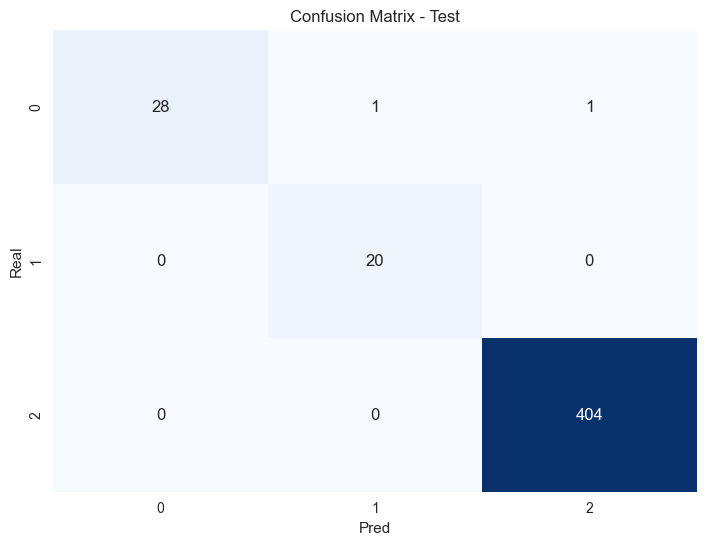

--------------------------------------------------
AUC Promedio = 1.0


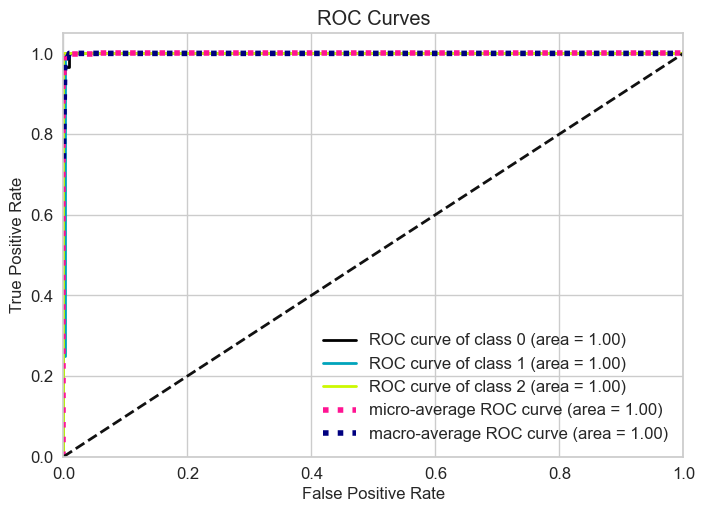

--------------------------------------------------


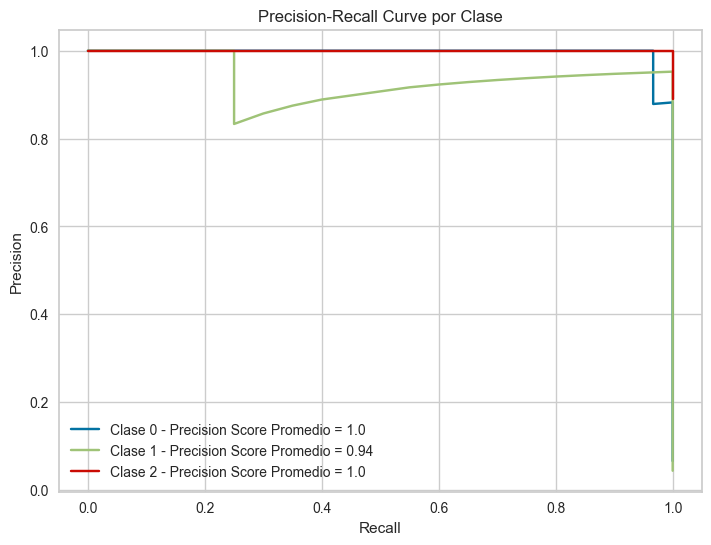

--------------------------------------------------


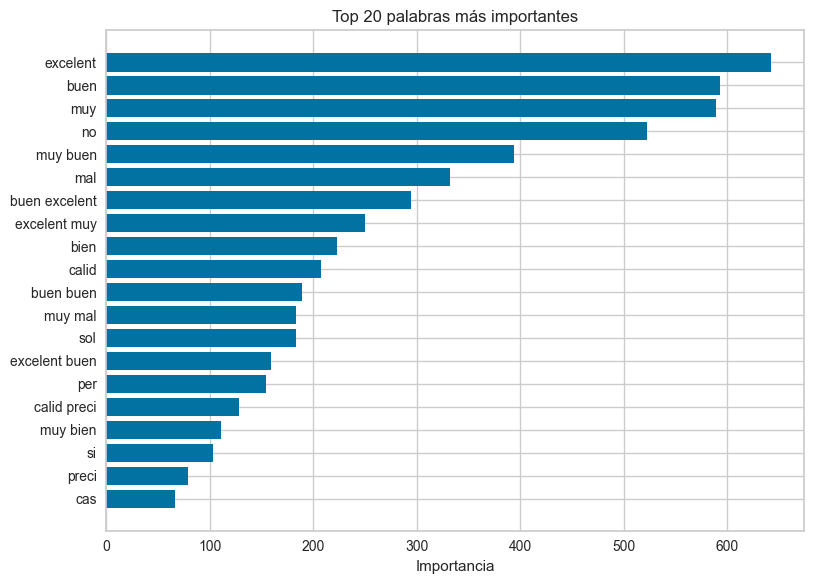

--------------------------------------------------


100%|===================| 1357/1362 [00:16<00:00]        

SHAP - Feature Importance - Clase: 0


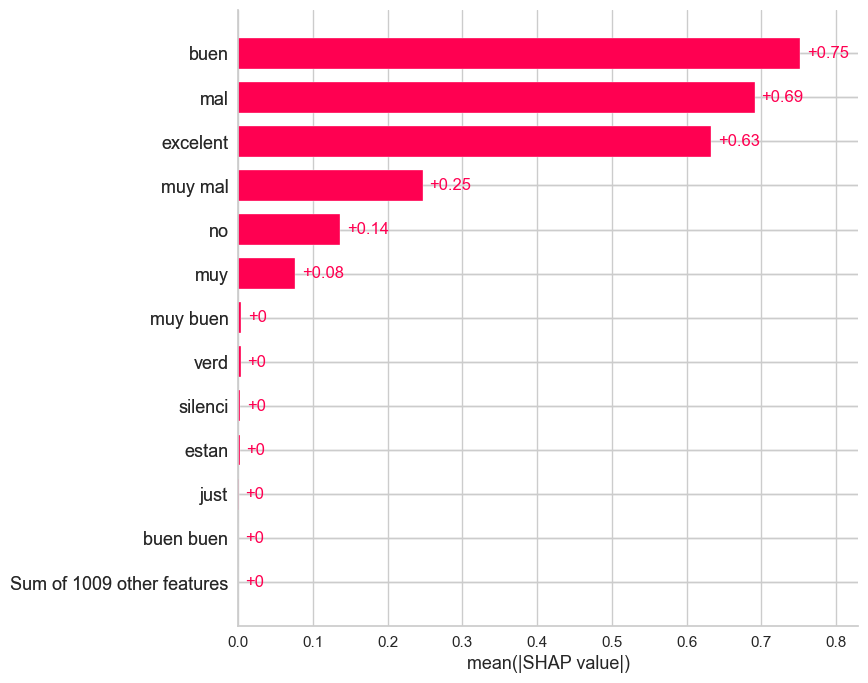

SHAP - Feature Importance - Clase: 1


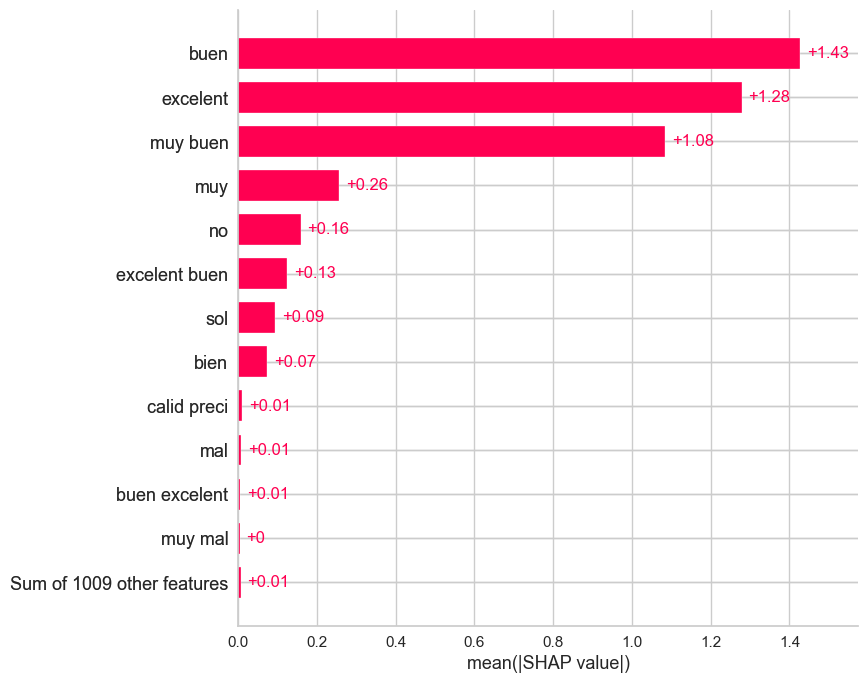

SHAP - Feature Importance - Clase: 2


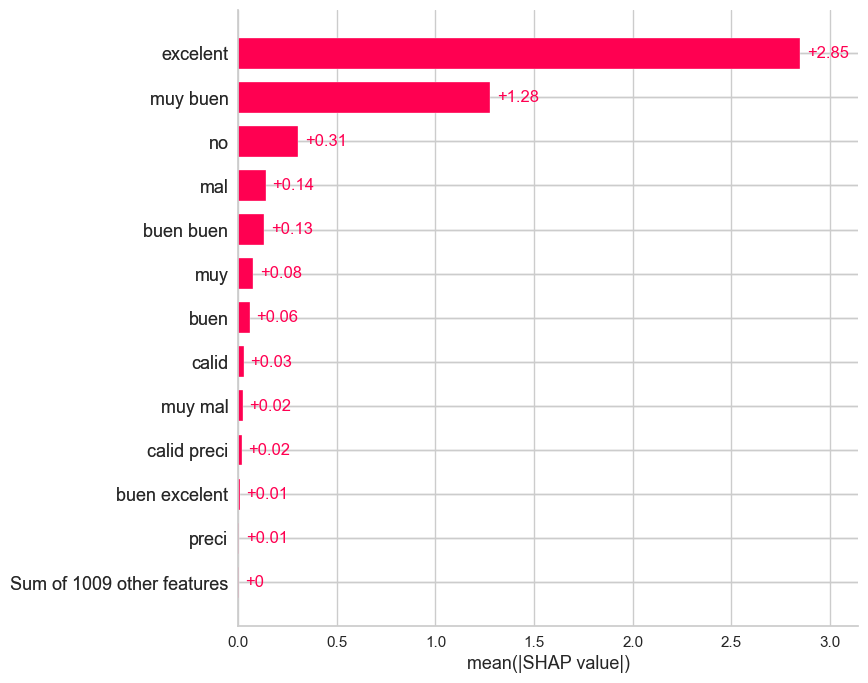

--------------------------------------------------


In [77]:
model_validation(baseline_lgbm, X_train_count, X_test_count, y_train, y_test)

### Validacion Modelo Tunning de Hiper-Parametros.

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
--------------------------------------------------
Clasification Report...
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       0.95      1.00      0.98        20
           2       1.00      1.00      1.00       404

    accuracy                           1.00       454
   macro avg       0.98      0.98      0.98       454
weighted avg       1.00      1.00      1.00       454

--------------------------------------------------


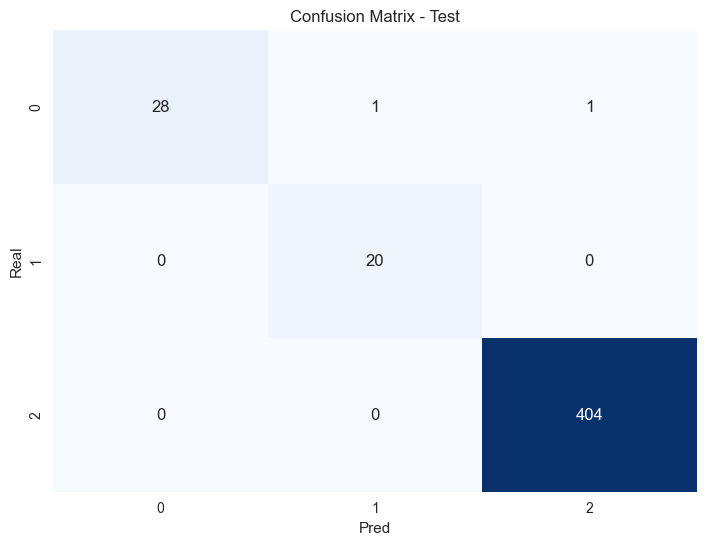

--------------------------------------------------
AUC Promedio = 1.0


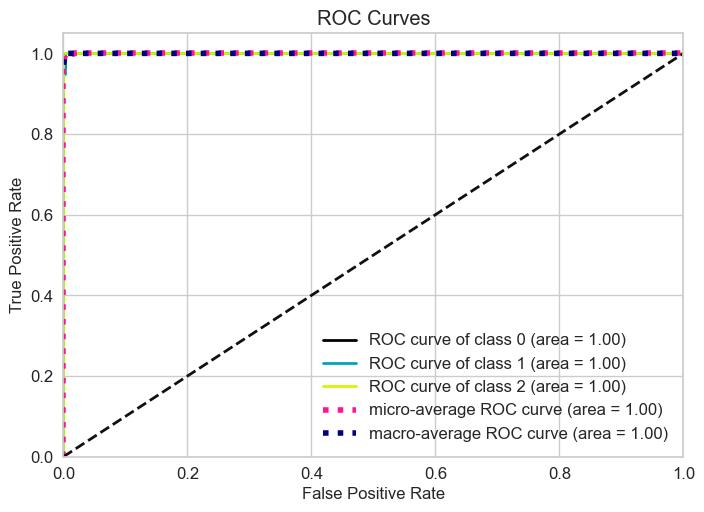

--------------------------------------------------


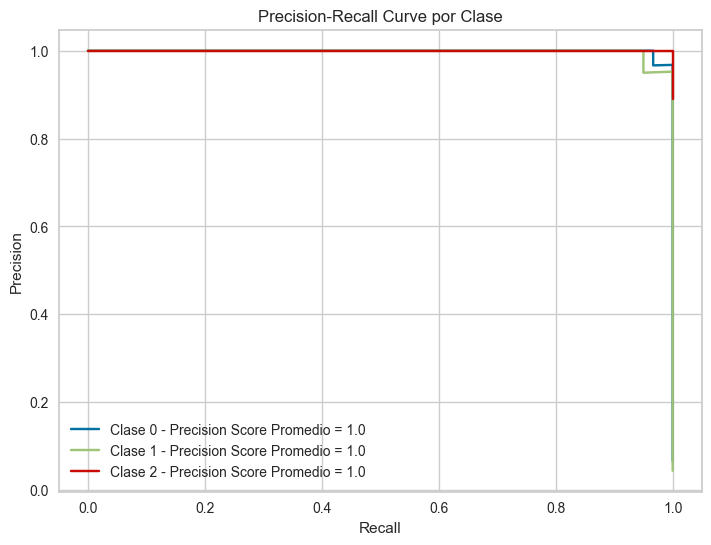

--------------------------------------------------


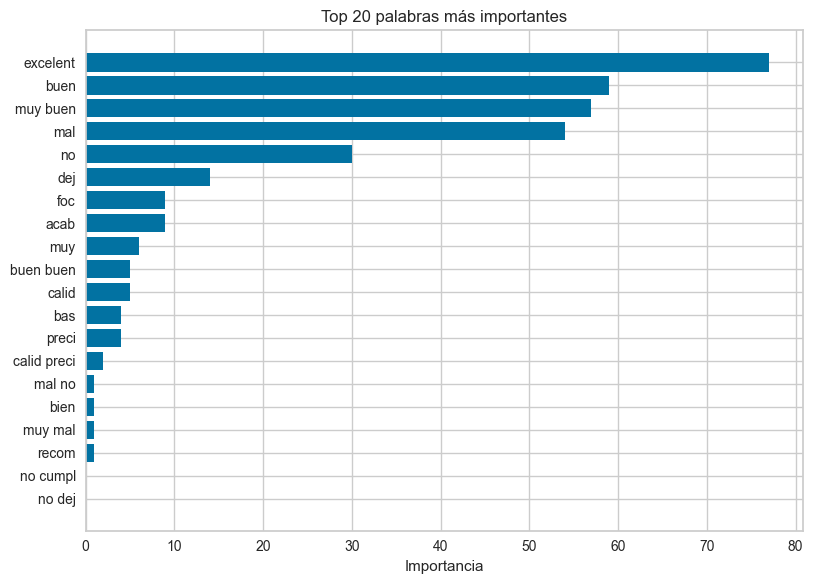

--------------------------------------------------
SHAP - Feature Importance - Clase: 0


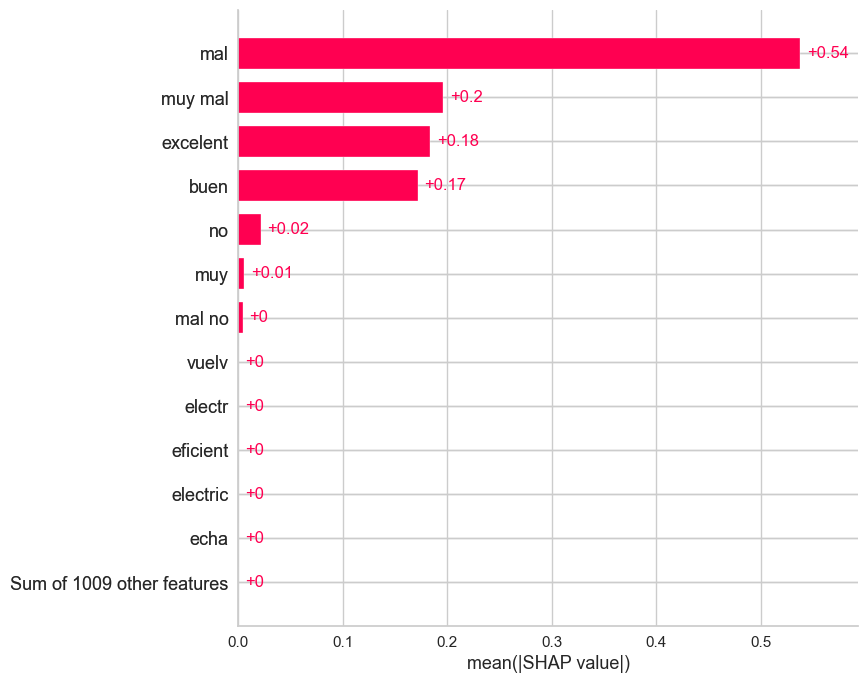

SHAP - Feature Importance - Clase: 1


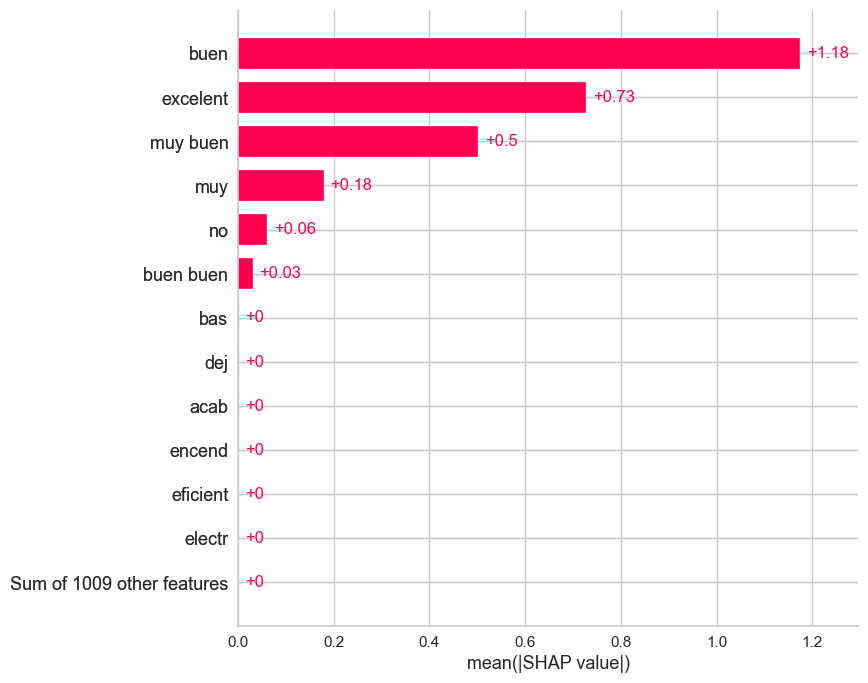

SHAP - Feature Importance - Clase: 2


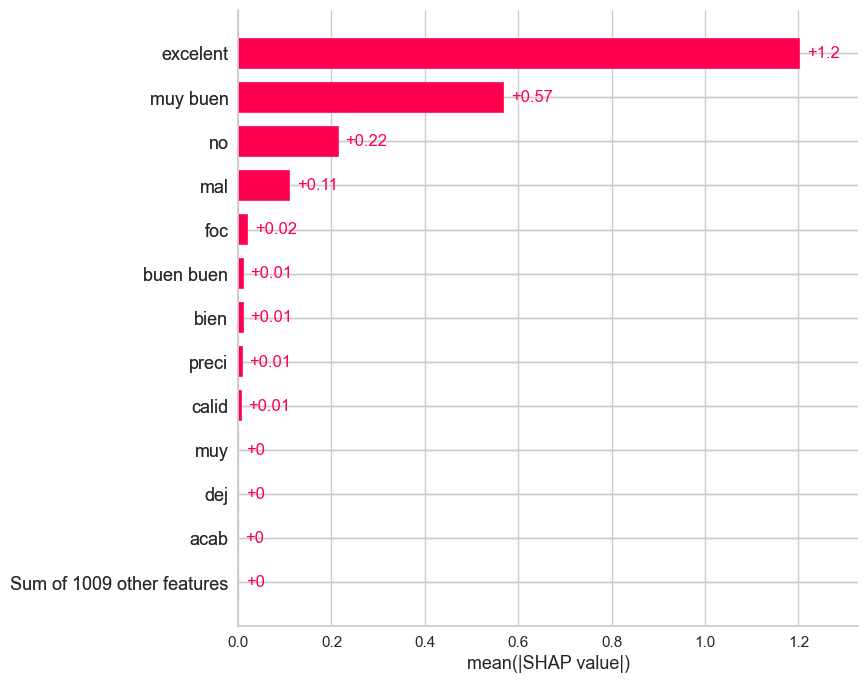

--------------------------------------------------


In [78]:
model_validation(tuned_lgbm, X_train_count, X_test_count, y_train, y_test)

Al observar las validaciones realizadas, tanto para el modelo baseline como el modelo al cual se le ajustaron los hiper-parametros, podemos ver que al realizar un ajuste, no estamos obteniendo grandes beneficios.

- Matriz de confusion: Los casos detectados por ambos modelos son iguales, ambos modelos tienen la misma cantidad de Falsos Positivos.

- Curvas ROC: ambos modelos tienen el mismo valor de AUC, lo que representa que el area bajo la curva es la misma.

    Cuando vemos las curvas ROC podemos ver que ambas se ajustan al modelo perfecto.

- Curvas Precision-Recall: Puede verse un mejor score promedio para el caso del modelo al cual se le ajustaron los hiperparametros, vemos que el valor paso de 0.94 a 1

- En cuanto a la feature importance y SHAP values, podemos ver que hay una diferencia entre los pesos que se les otorga a las diferentes variables.

    Puede verse que para la clasificacion de la clase 0, en el modelo donde se ajustaron los hiper-parametros, hay palabras que describben mejor a la clase de comentarios negativos, como por ejemplo "mal", "muy mal", etc.

    Lo que esto indicaria es que este ultimo modelo podria ser mas robusto para predecir la clase negativa, debido a que sus variables hacen mas enfasis en los textos que conotan negatividad.

---

# Export Modelo Ganador.

Ahora procederemos a exportar el modelo ganador.

Algo que podria mejorar el modelo, ya una vez evaluado y seleccionado los mejores hiperparametros, seria reentrenar el modelo con el 100% de los datos.

Esto es una buena practica ya que una vez que validamos el modelo no tendria sentido desperdiciar datos de entrenamiento.

De aqui obtenemos un modelo final listo para produccion o para testeo.

NOTA: Esto lo hago ya que se que el entrenamiento es rapido, debido a que tenemos muy poca cantidad de datos, si el dataset fuera mayor en complejidad y tamaño evaluaria si esto es necesario, si la complejidad que induce es mayor al beneficio obtenido.

La realidad es que el modelo ya esta performando mas que bien, pero esto ejemplificaria un boost o algo extra que podria agregarse para mejorar algo mas el modelo.

In [79]:
# Otbengo los hiperparametros del modelo ganadro.
# Si el modelo ganador llegara a ser el mismo que el baseline, los hiperparametros no cambiarian.
best_params = tuned_lgbm.get_params()

X_final = pd.concat([X_train_count, X_test_count])
y_final = pd.concat([y_train, y_test])
df_final = X_final.merge(y_final, left_index=True, right_index=True)

# Ya que hay columnas con nombres que contienen espacios, los reemplazo por guiones bajos.
X_final.columns = X_final.columns.str.replace(' ', '_')

final_model = lgb.LGBMClassifier(**best_params)

final_model.fit(X_final, y_final)

joblib.dump(final_model, model_output + output_name)

# Ademas guardamos el vectorizer con el cual se entreno el modelo.
joblib.dump(vectorizer_instance, vectorizer_output + vectorizer_name)

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 487
[LightGBM] [Info] Number of data points in the train set: 1418, number of used features: 200
[LightGBM] [Info] Start training from score -2.713708
[LightGBM] [Info] Start training from score -3.146129
[LightGBM] [Info] Start training from score -0.115758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

['./models/word_vectorizer/fit_count_vectorizer.pkl']

---